# Compare fingerprint-based scores to MCES
Here using pre-computed rascal MCES scores.
Those were computed for randomly selected pairs of compounds from the **ms2structures dataset** with a mass difference <= 100 Da (to avoid obviously distinct compounds).

In [1]:
import os
import sys
from pathlib import Path
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator

ROOT = Path(os.getcwd()).parents[0]

path_data = os.path.join(Path(ROOT), "data")

In [2]:
# Add source code path
sys.path.insert(0, os.path.join(ROOT, "src"))

# Import funtion/classes from source code
from fingerprint_computation import FingerprintGenerator, SparseFingerprintGenerator, compute_fingerprints_from_smiles
from metrics import ruzicka_similarity_matrix_sparse, jaccard_similarity_matrix_sparse
from metrics import ruzicka_similarity_matrix, jaccard_similarity_matrix

from map4neo import MAP4neo
from mapmorgan import MAP4Morgan

ModuleNotFoundError: No module named 'map4neo'

In [21]:
from typing import List
from rdkit.Chem import Mol
from map4 import MAP4
#from map4neo import MAP4neo

def compute_map_fingerprints_from_smiles(smiles, map_generator):
    
    molecules: List[Mol] = [Chem.MolFromSmiles(s) for s in smiles]
    fingerprints_map: np.ndarray = map_generator.calculate_many(
        molecules,
        number_of_threads=32,
        verbose=True,
    )
    return list(fingerprints_map)


def compute_sparse_map_fingerprints_from_smiles(
    smiles,
    map_generator,
    count=False,
    ):
    molecules: List[Mol] = [Chem.MolFromSmiles(s) for s in smiles]
    fingerprints_map: np.ndarray = map_generator.calculate_many_sparse(
        molecules,
        number_of_threads=32,
        verbose=True,
        count=count,
    )
    return list(fingerprints_map)


def compute_sparse_map_fingerprints_from_smiles_serial(
        smiles,
        map_generator
        ):

    molecules: List[Mol] = [Chem.MolFromSmiles(s) for s in smiles]
    fingerprints = []
    for mol in tqdm(molecules):
        fp_bits = map_generator._calculate(mol)
        fingerprints.append(np.sort(map_generator.encoder.hash(fp_bits)))
    return fingerprints

## Import ms2structures dataset and rascal scores

In [3]:
filename = "compounds_ms2structures.csv"
compounds = pd.read_csv(os.path.join(path_data, filename))
compounds.head()

,inchikey,smiles,mass,cf_class,cf_subclass,cf_superclass,formula,npc_class_results,npc_pathway_results,npc_superclass_results
0,AAAQFGUYHFJNHI,CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...,423.146204,Benzodiazepines,"1,4-benzodiazepines",Organoheterocyclic compounds,C22H22ClN5O2,NaN,Alkaloids,NaN
1,AABFWJDLCCDJJN,COC1=CC2=C(C=C1)NC3=C2C=CN=C3C4=CC=CC5=CC=CC=C54,324.126264,Harmala alkaloids,NaN,Alkaloids and derivatives,C22H16N2O,Carboline alkaloids,Alkaloids,Tryptophan alkaloids
2,AABILZKQMVKFHP,C/C=C(/C)\C(=O)O[C@H]1CC[N+]2([C@@H]1C(=CC2)CO...,427.220624,NaN,NaN,Alkaloids and derivatives,C21H33NO8,Pyrrolizidine alkaloids,Alkaloids,Ornithine alkaloids
3,AABUHSBGEIUSRJ,CC(=O)NC1=CC=C(C=C1)NC(=O)C=CC2=CC=CC=C2,280.120724,Cinnamic acids and derivatives,Cinnamic acid amides,Phenylpropanoids and polyketides,C17H16N2O2,Cinnamic acid amides,Shikimates and Phenylpropanoids,Phenylpropanoids (C6-C3)
4,AABUKWVVUWBZCS,C1=CC=C(C=C1)C2=C(C(=O)OC3=C2C=CC(=C3)O)C4=CC=...,314.094724,Neoflavonoids,Neoflavones,Phenylpropanoids and polyketides,C21H14O3,Neoflavonoids,Shikimates and Phenylpropanoids,Flavonoids


In [4]:
compounds.shape

(37811, 10)

In [5]:
#rascal_scores = pd.read_csv(os.path.join(path_data, "rascal_benchmarking_set.csv"))
rascal_scores = pd.read_csv("rascal_mces_scores_250312.csv")
rascal_scores.head()

,inchikey1,inchikey2,mass_diff,mass1,mass2,rascal,timeout
0,AAAQFGUYHFJNHI,AJJHWJZAMWDEKK,6.01142,423.146204,429.157624,0.136461,False
1,AAAQFGUYHFJNHI,AKEJXNSCRNEUTK,70.61000,423.904000,494.514000,0.102407,False
2,AAAQFGUYHFJNHI,BALQLFHMRMGAIZ,1.63200,423.904000,425.536000,0.032553,False
3,AAAQFGUYHFJNHI,BVOMWOZDWVPLIR,21.65200,423.904000,445.556000,0.029101,False
4,AAAQFGUYHFJNHI,BXWXZJYUVKDFPR,39.98283,423.146204,383.163374,0.031486,False


In [6]:
rascal_scores.shape

(2449617, 7)

# Compare MCES to fingerprint based scores

In [7]:
compounds_mapper = compounds.copy()
compounds_mapper["index"] = compounds_mapper.index
compounds_mapper = compounds_mapper.set_index("inchikey")
compounds_mapper = compounds_mapper.iloc[:, -1]
compounds_mapper

inchikey
AAAQFGUYHFJNHI        0
AABFWJDLCCDJJN        1
AABILZKQMVKFHP        2
AABUHSBGEIUSRJ        3
AABUKWVVUWBZCS        4
                  ...  
ZZYXNRREDYWPLN    37806
ZZZJZEXRSVMPPV    37807
ZZZQXCUPAJFVBN    37808
ZZZRUAITSXLWBH    37809
ZZZYHIMVKOHVIH    37810
Name: index, Length: 37811, dtype: int64

In [8]:
# just checking
not_in_compounds = np.setdiff1d(rascal_scores["inchikey1"].values, compounds.inchikey.values)

In [9]:
not_in_compounds

array([], dtype=object)

In [12]:
experiments = [
    ("morgan2_count", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096), True),
    ("morgan3_count", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), True),
    #("morgan6_count", rdFingerprintGenerator.GetMorganGenerator(radius=6, fpSize=4096), True),
    ("morgan9_count", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), True),
    ("morgan12_count", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), True),
    ("morgan2_binary", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096), False),
    ("morgan3_binary", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), False),
    ("rdkit", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096), False),
    ("map2", MAP4(dimensions=4096, radius=1, include_duplicated_shingles=False), False),
    ("map4", MAP4(dimensions=4096, radius=2, include_duplicated_shingles=False), False),
    ("morgan2_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096), True),
    ("morgan3_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), True),
    #("morgan6_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=6, fpSize=4096), True),
    ("morgan9_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096), True),
    ("morgan12_count_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=12, fpSize=4096), True),
    ("morgan2_binary_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096), False),
    ("morgan3_binary_sparse", rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096), False),
    ("rdkit_sparse", rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096), False),
    ("map2_sparse", MAP4(dimensions=4096, radius=1, include_duplicated_shingles=False), False),
    ("map4_sparse", MAP4(dimensions=4096, radius=2, include_duplicated_shingles=False), False),
]

In [13]:
def compare_scores(
    result_df, fingerprints, metric_function, label1, label2, filename,
):
    mask1 = result_df['timeout'] == False
    result_df = result_df[mask1.values].fillna(0.0)
    
    
    # Map inchikey to indices in the compounds dataframe
    mapped_indices1 = compounds_mapper.loc[result_df["inchikey1"].values].values
    mapped_indices2 = compounds_mapper.loc[result_df["inchikey2"].values].values

    # Get rascalMCES similarities
    rascal_similarities = result_df['rascal'].values
    
    # Extract fingerprint-based similarities using the mapped indices
    fingerprint_similarities = []
    for i, j in zip(mapped_indices1, mapped_indices2):
        if isinstance(fingerprints[i], tuple):
            fingerprint_similarities.append(metric_function(
                fingerprints[i][0], fingerprints[i][1], fingerprints[j][0], fingerprints[j][1]))
        else:
            fingerprint_similarities.append(metric_function(fingerprints[i], fingerprints[j]))
    
    fingerprint_similarities = np.array(fingerprint_similarities)

    correlation = np.corrcoef(rascal_similarities, fingerprint_similarities)[1, 0]
    print(f"Pearson correlation: {correlation:.4f}")

    heatmap_comparison_flat(
        rascal_similarities, fingerprint_similarities,
        label1, label2, filename=filename
    )
    return correlation

In [14]:
rascal_scores.shape[0] / 37811**2

0.001713412221853691

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patheffects as path_effects
from mpl_toolkits.axes_grid1 import make_axes_locatable


def heatmap_comparison_flat(similarities1, similarities2, label1, label2, bins=50,
                       colormap="viridis",
                       add_region_percentage=True, filename=None,
                      ):
    """
    Generates a heatmap comparison of two similarity matrices.
    
    Parameters:
    similarities1 (ndarray): First similarity array.
    similarities2 (ndarray): Second similarity array.
    label1 (str): Label for the x-axis.
    label2 (str): Label for the y-axis.
    bins (int, optional): Number of bins for the 2D histogram (default: 50).
    colormap (str, optional): Colormap used for visualization (default: "viridis").
    filename (str, optional): If provided, saves the heatmap to the specified file.
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
    
    # Select upper triangle indices to ignore diagonal if necessary
    n = similarities1.shape[0]
    
    # Compute the 2D histogram
    hist, x_edges, y_edges = np.histogram2d(
        similarities1, 
        similarities2, 
        bins=bins
    )
    
    # Plot the heatmap using imshow with a logarithmic color scale
    im = ax.imshow(
        hist.T, origin='lower', aspect='equal',
        extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
        cmap=colormap, norm=LogNorm(vmin=1, vmax=np.max(hist))
    )
    
    # Create an axis of the same height for the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("Count")
    
    # Compute total count for percentage calculations
    total_count = len(similarities1)
    
    # Add text annotations for each 5x5 section of bins
    step = bins // 5
    for i in range(0, bins, step):
        for j in range(0, bins, step):
            sub_matrix = hist[i:i+step, j:j+step]
            subsection_sum = np.sum(sub_matrix)
            
            if subsection_sum > 0 and add_region_percentage:
                # Compute the center of the bin for text placement
                x_center = (x_edges[i] + x_edges[min(i + step, bins - 1)]) / 2
                y_center = (y_edges[j] + y_edges[min(j + step, bins - 1)]) / 2
                
                # Add text annotation
                ax.text(
                    x_center, y_center, f"{(100 * subsection_sum / total_count):.2f}%",
                    color="white", ha="center", va="center", fontsize=6, zorder=2
                )
    
    # Configure grid, labels, and layout
    ax.grid(True, zorder=1)
    ax.set_xlabel(label1)
    ax.set_ylabel(label2)
    plt.tight_layout()
    
    # Save plot if a filename is provided
    if filename:
        plt.savefig(filename)
    
    # Show the plot
    plt.show()

In [16]:
path_results = os.path.join(Path(ROOT), "experiments")

In [17]:
from metrics import jaccard_index, jaccard_index_sparse, ruzicka_similarity, ruzicka_similarity_sparse_numba

----- Found existing results for experiment: morgan2_count -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: morgan3_count -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: morgan9_count -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: morgan12_count -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: morgan2_binary -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: morgan3_binary -----
----- (experiment will be skipped) -----
----- Found existing results for experiment: rdkit -----
----- (experiment will be skipped) -----
----- Experiment: map2 -----


Calculating fingerprints:   0%|                                                                               …

Collected 37811 fingerprints.
Pearson correlation: 0.4411


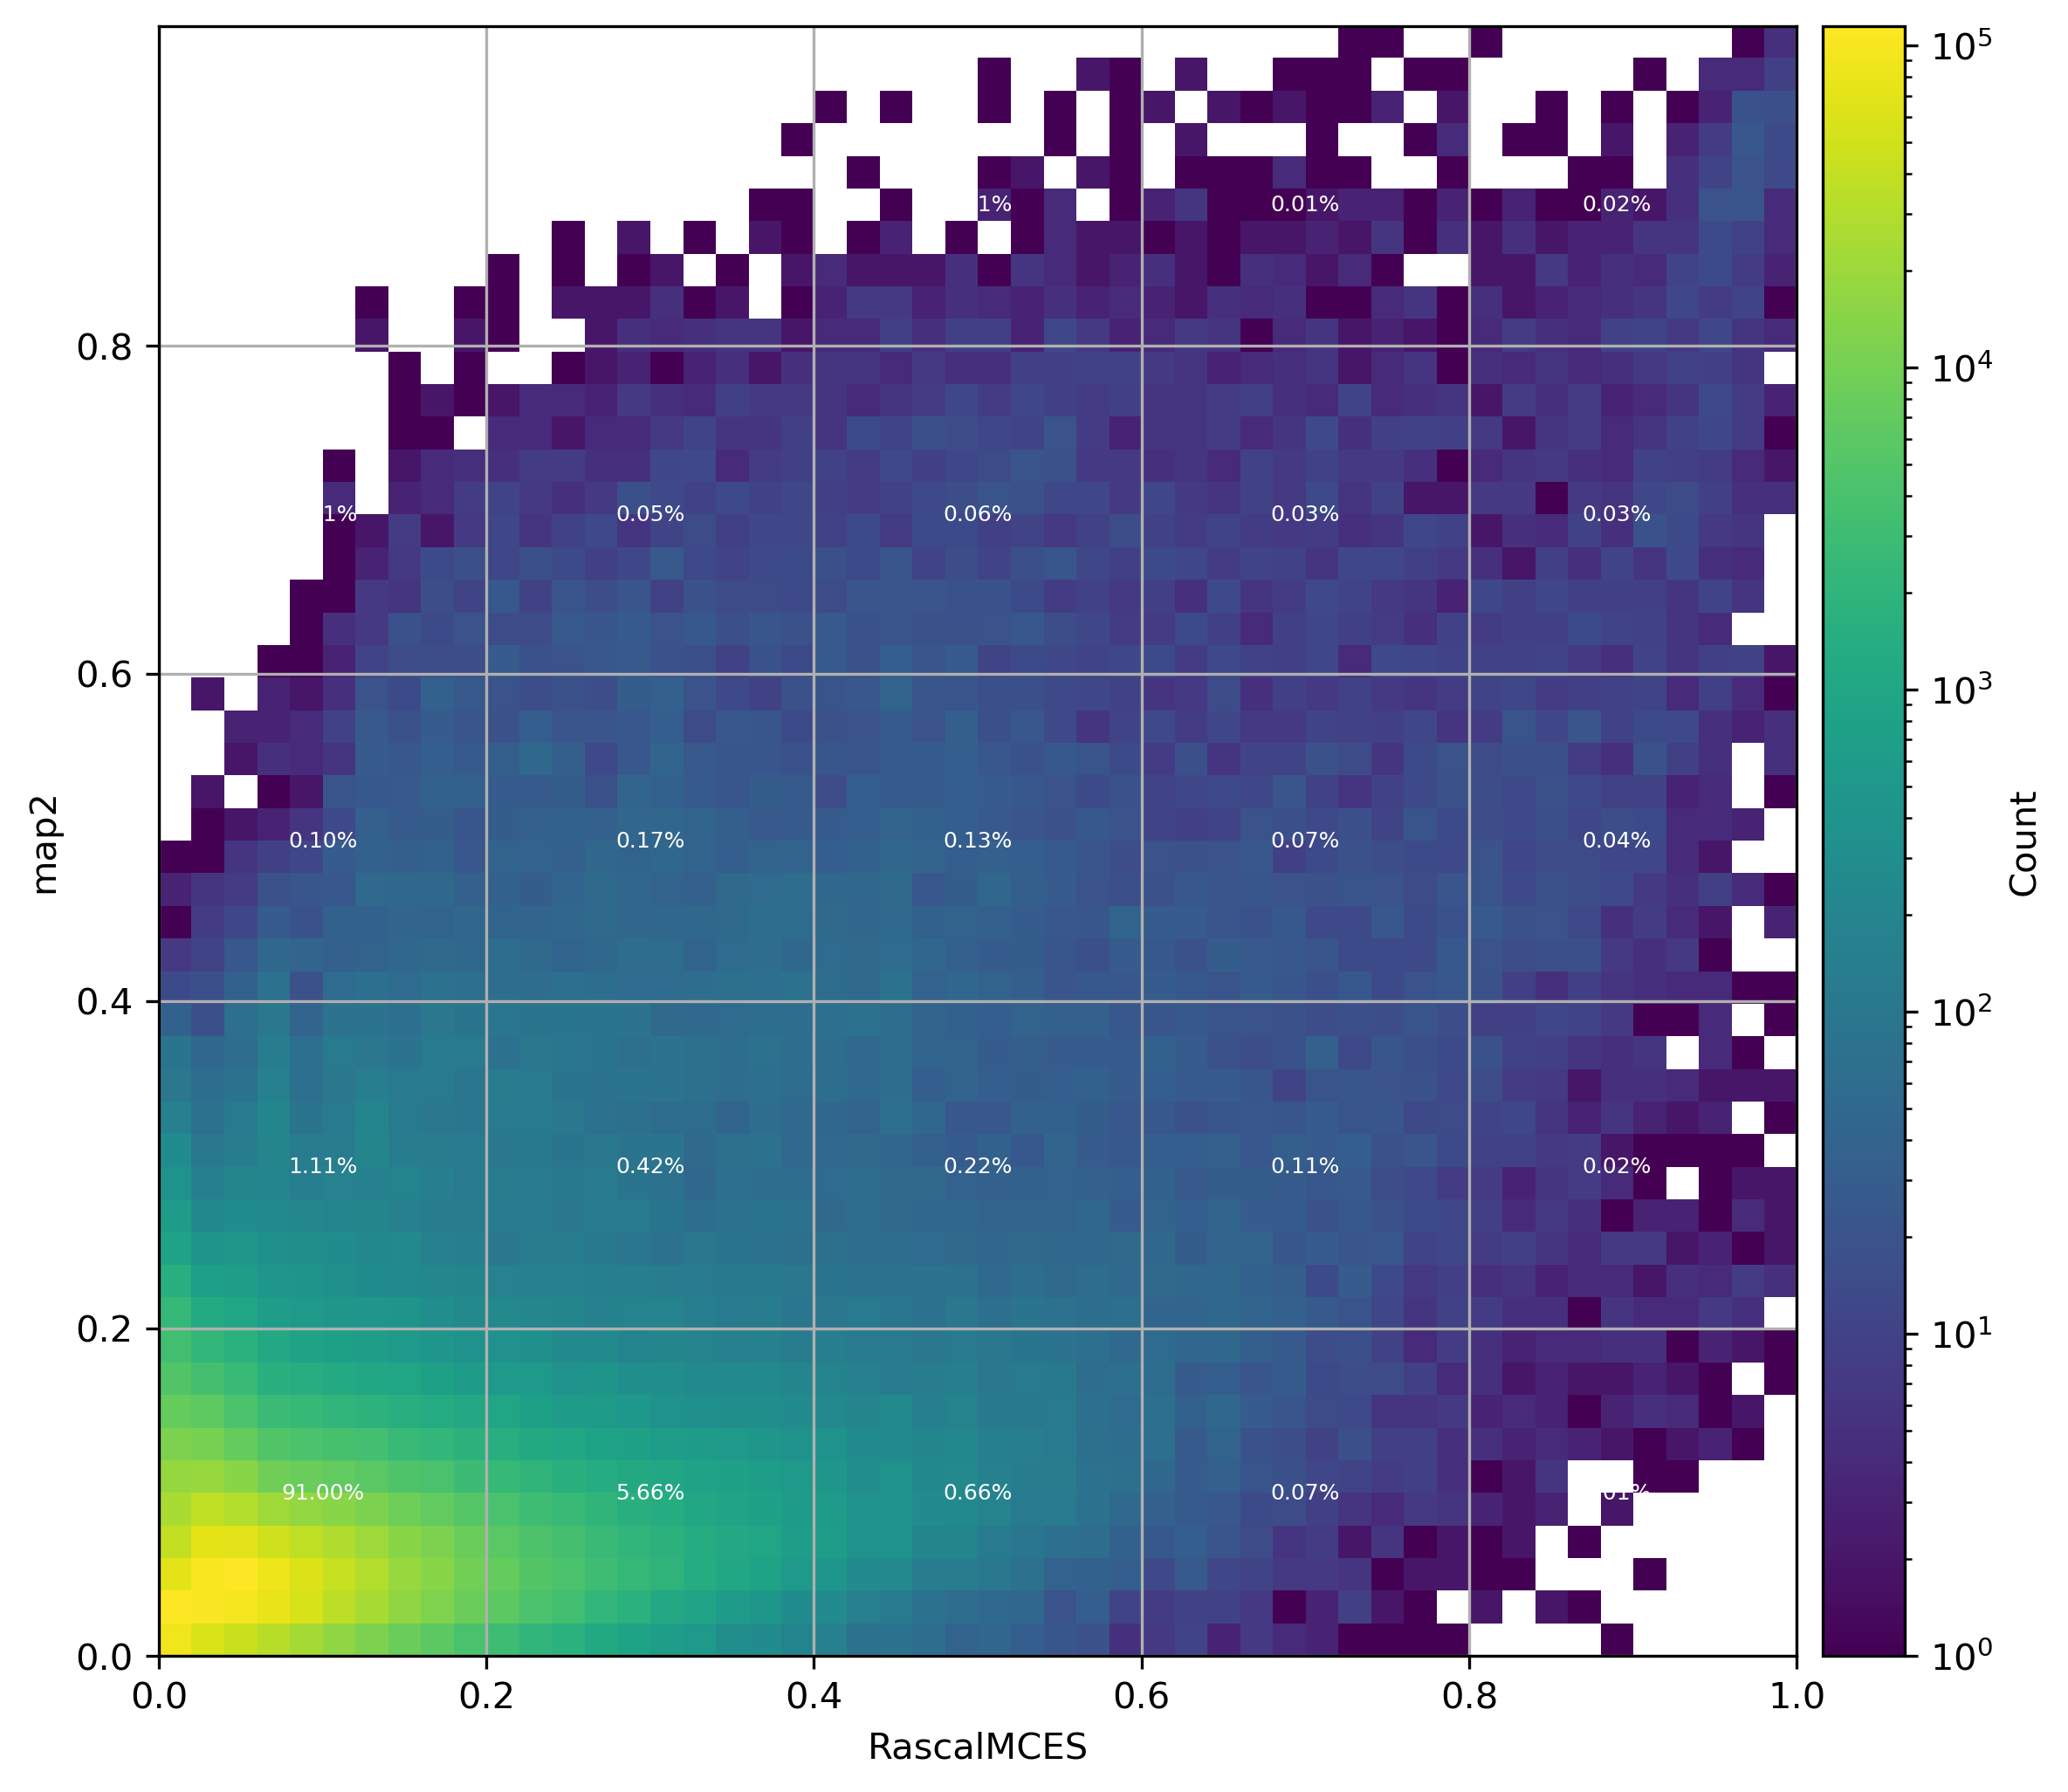

Pearson correlation between map2 and rascalMCES: 0.44105
----- Experiment: map4 -----


Calculating fingerprints:   0%|                                                                               …

Collected 37811 fingerprints.
Pearson correlation: 0.1309


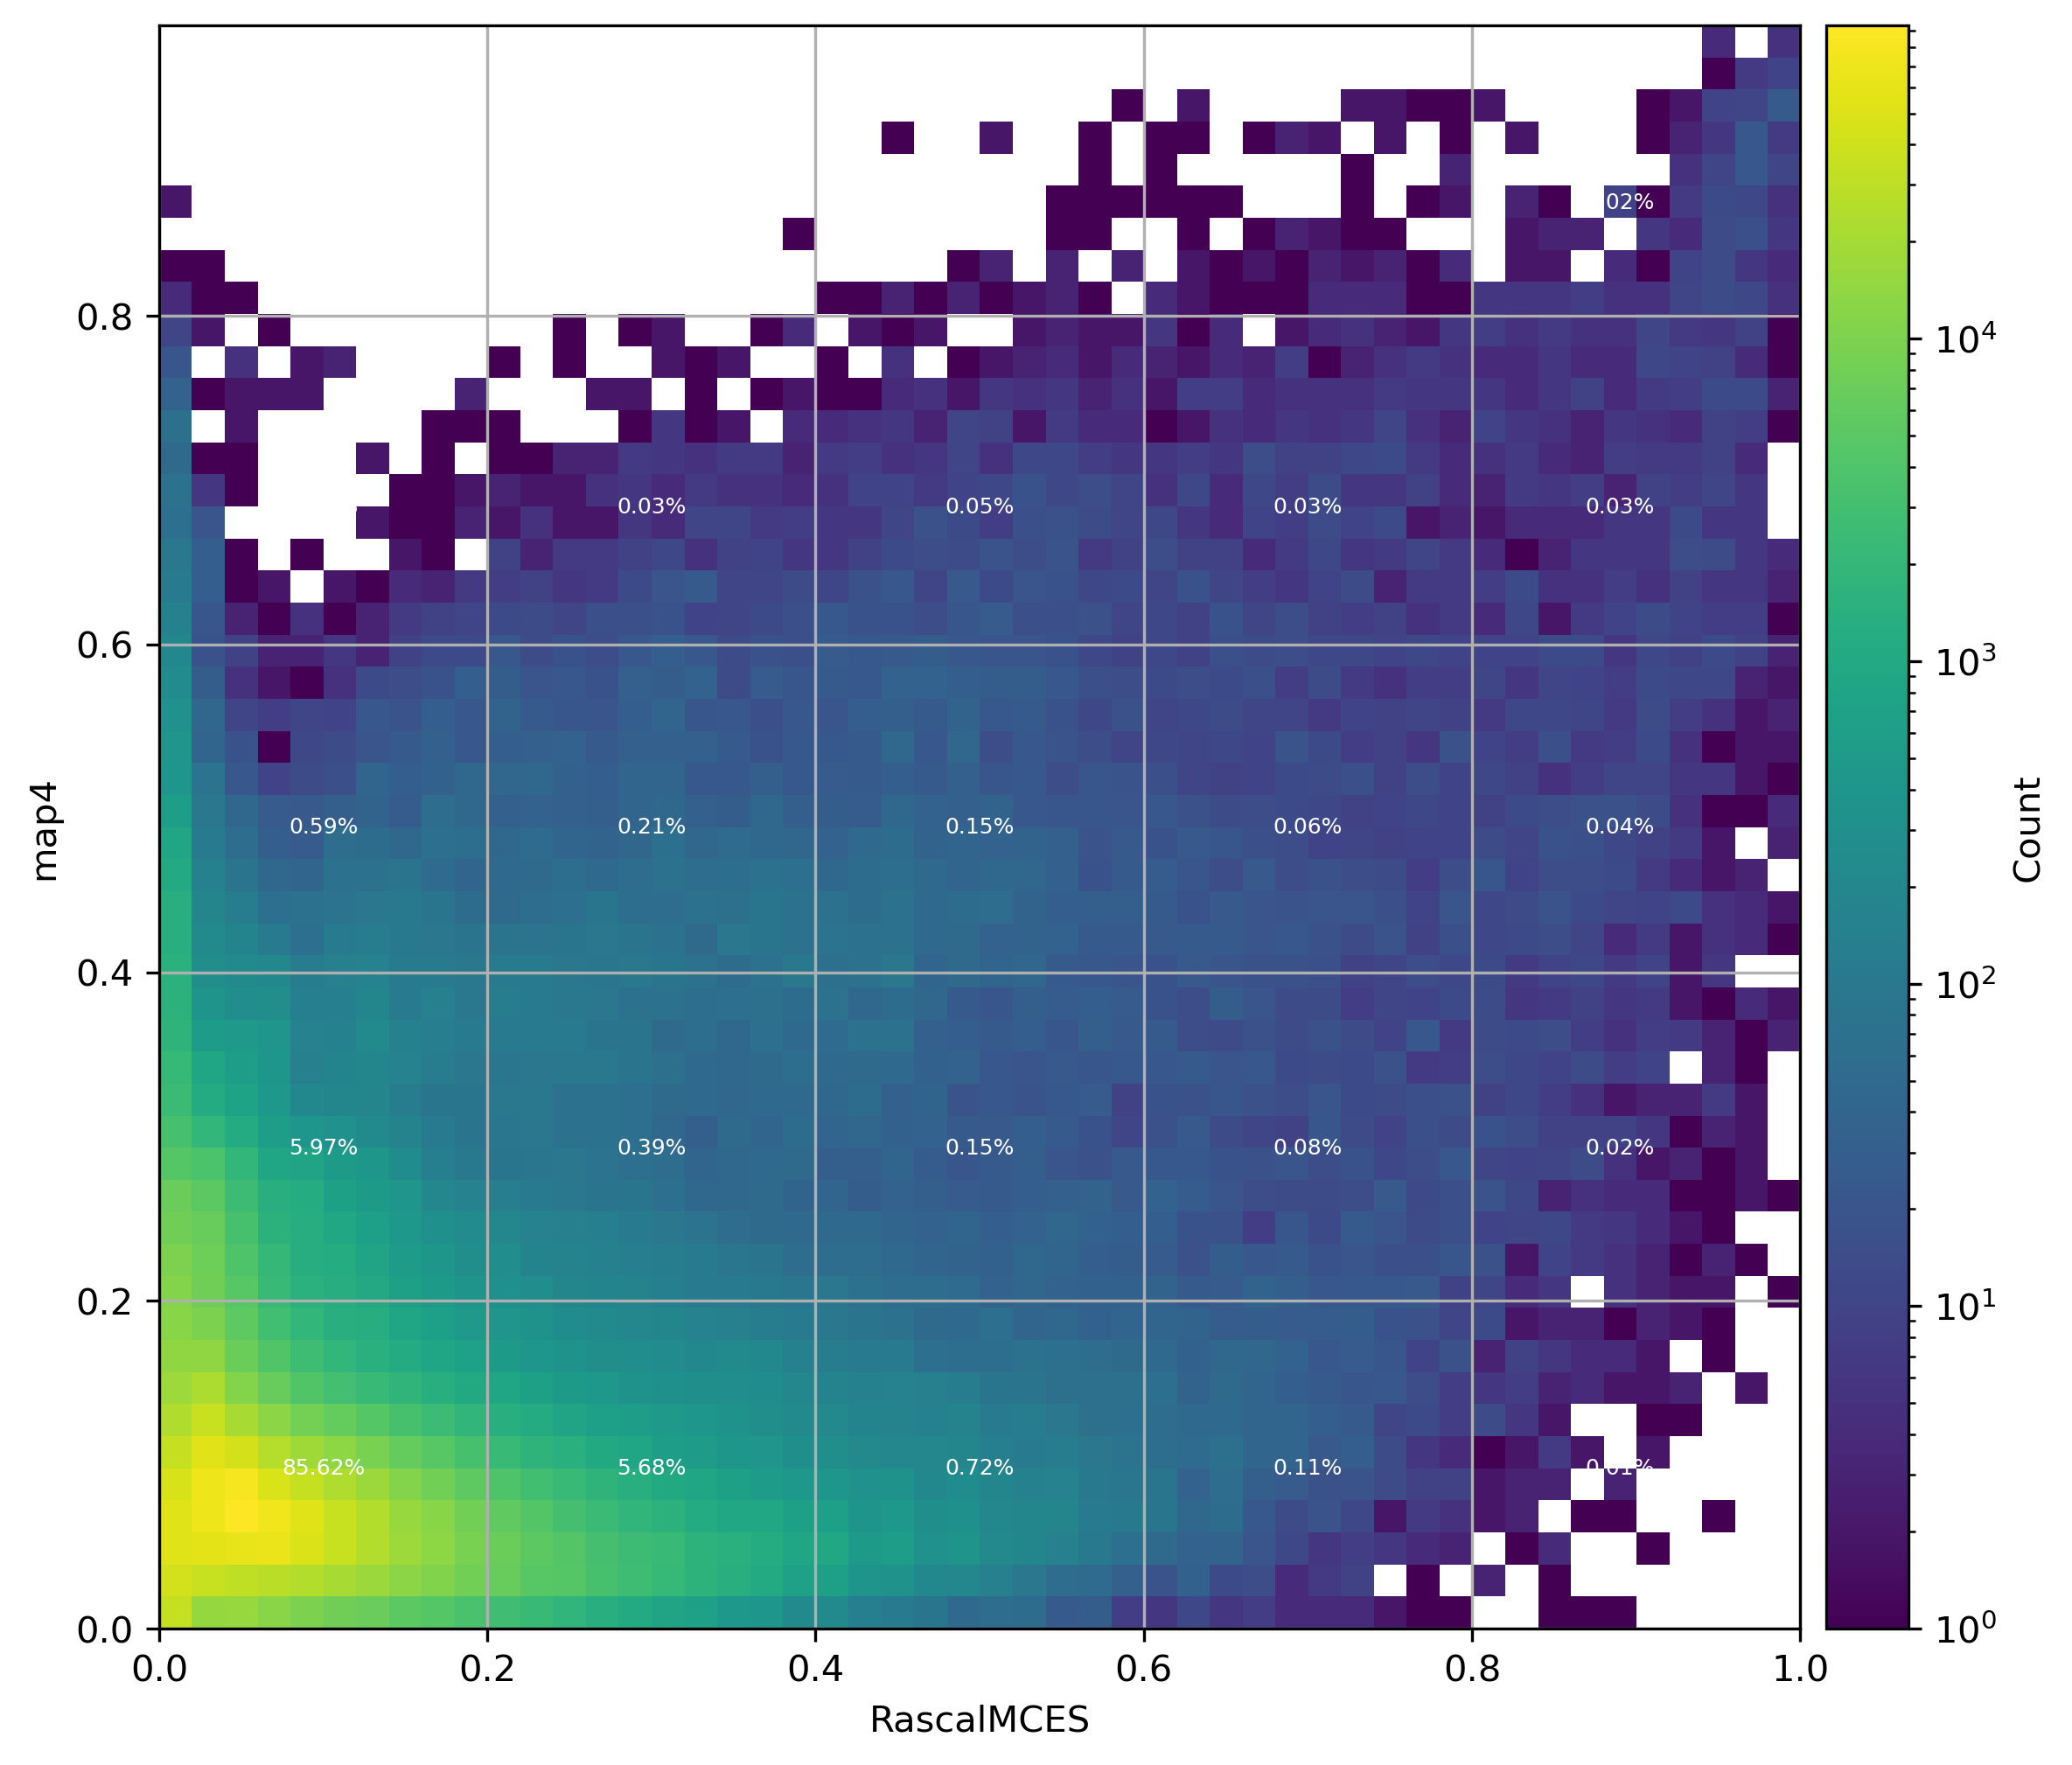

Pearson correlation between map4 and rascalMCES: 0.13086
----- Experiment: morgan2_count_sparse -----


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37811/37811 [00:05<00:00, 7287.18it/s]


Collected 37811 sparse fingerprints.
Pearson correlation: 0.5628


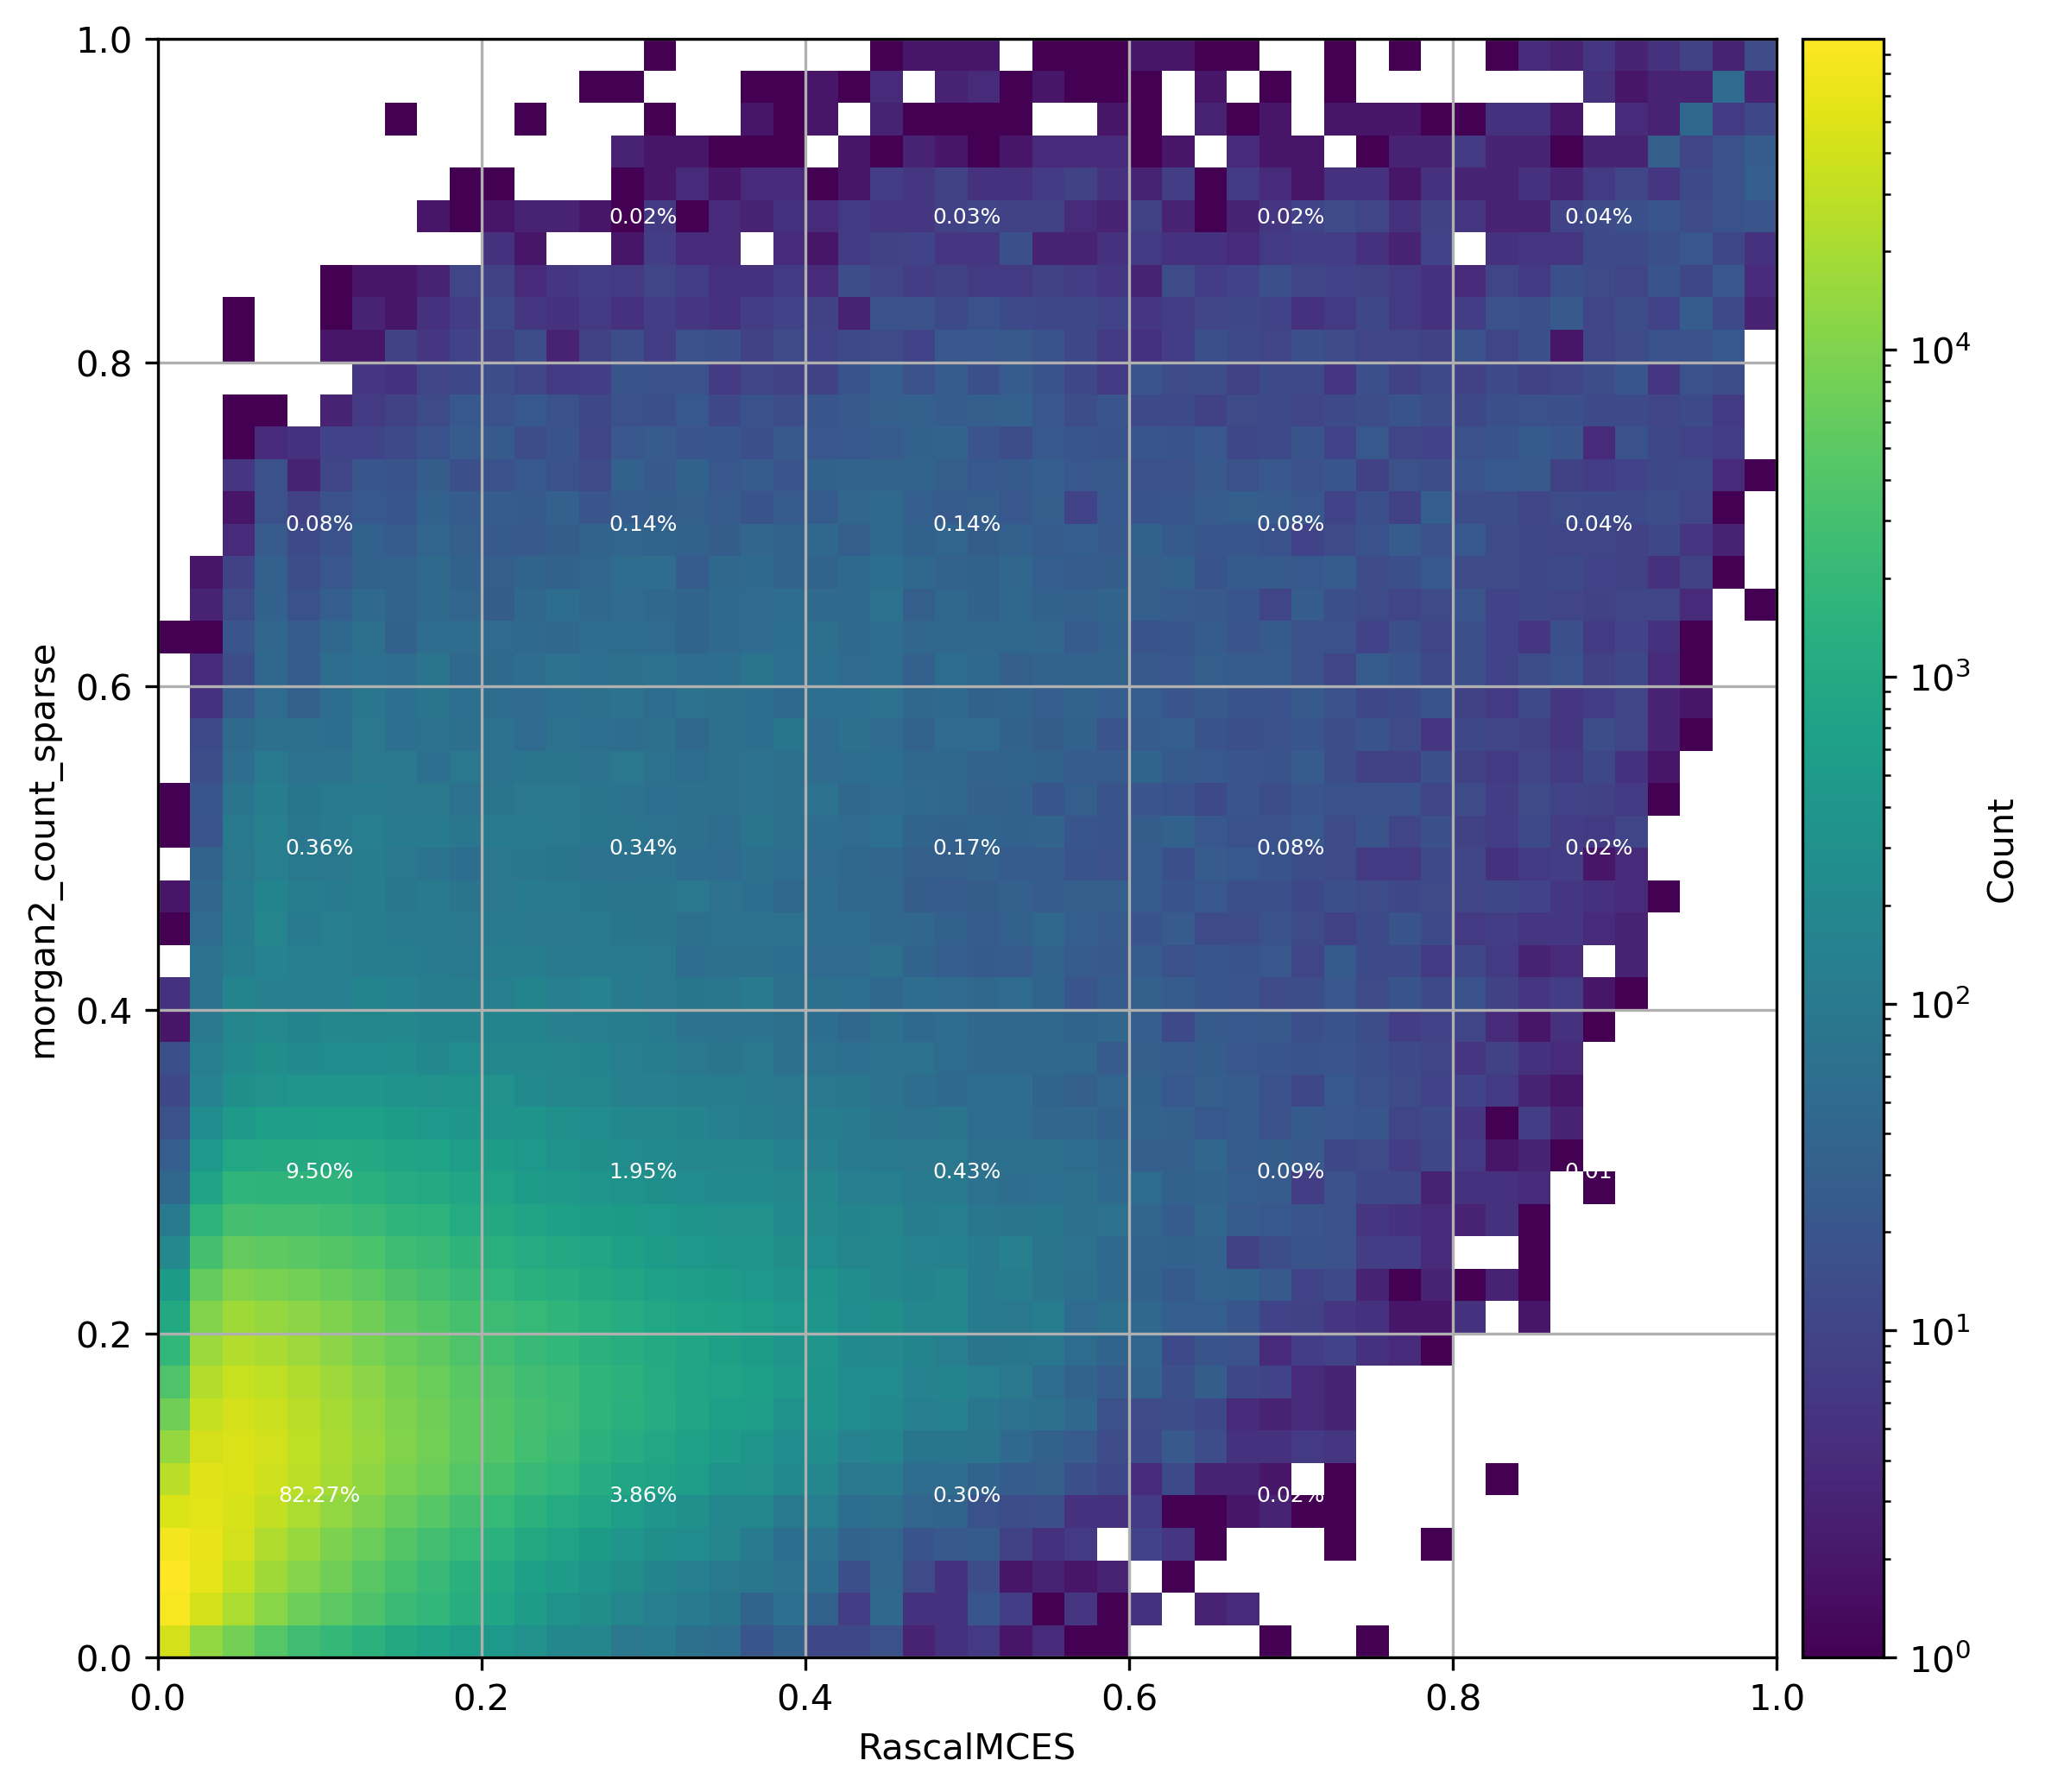

Pearson correlation between morgan2_count_sparse and rascalMCES: 0.56280
----- Experiment: morgan3_count_sparse -----


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37811/37811 [00:05<00:00, 6377.52it/s]


Collected 37811 sparse fingerprints.
Pearson correlation: 0.5769


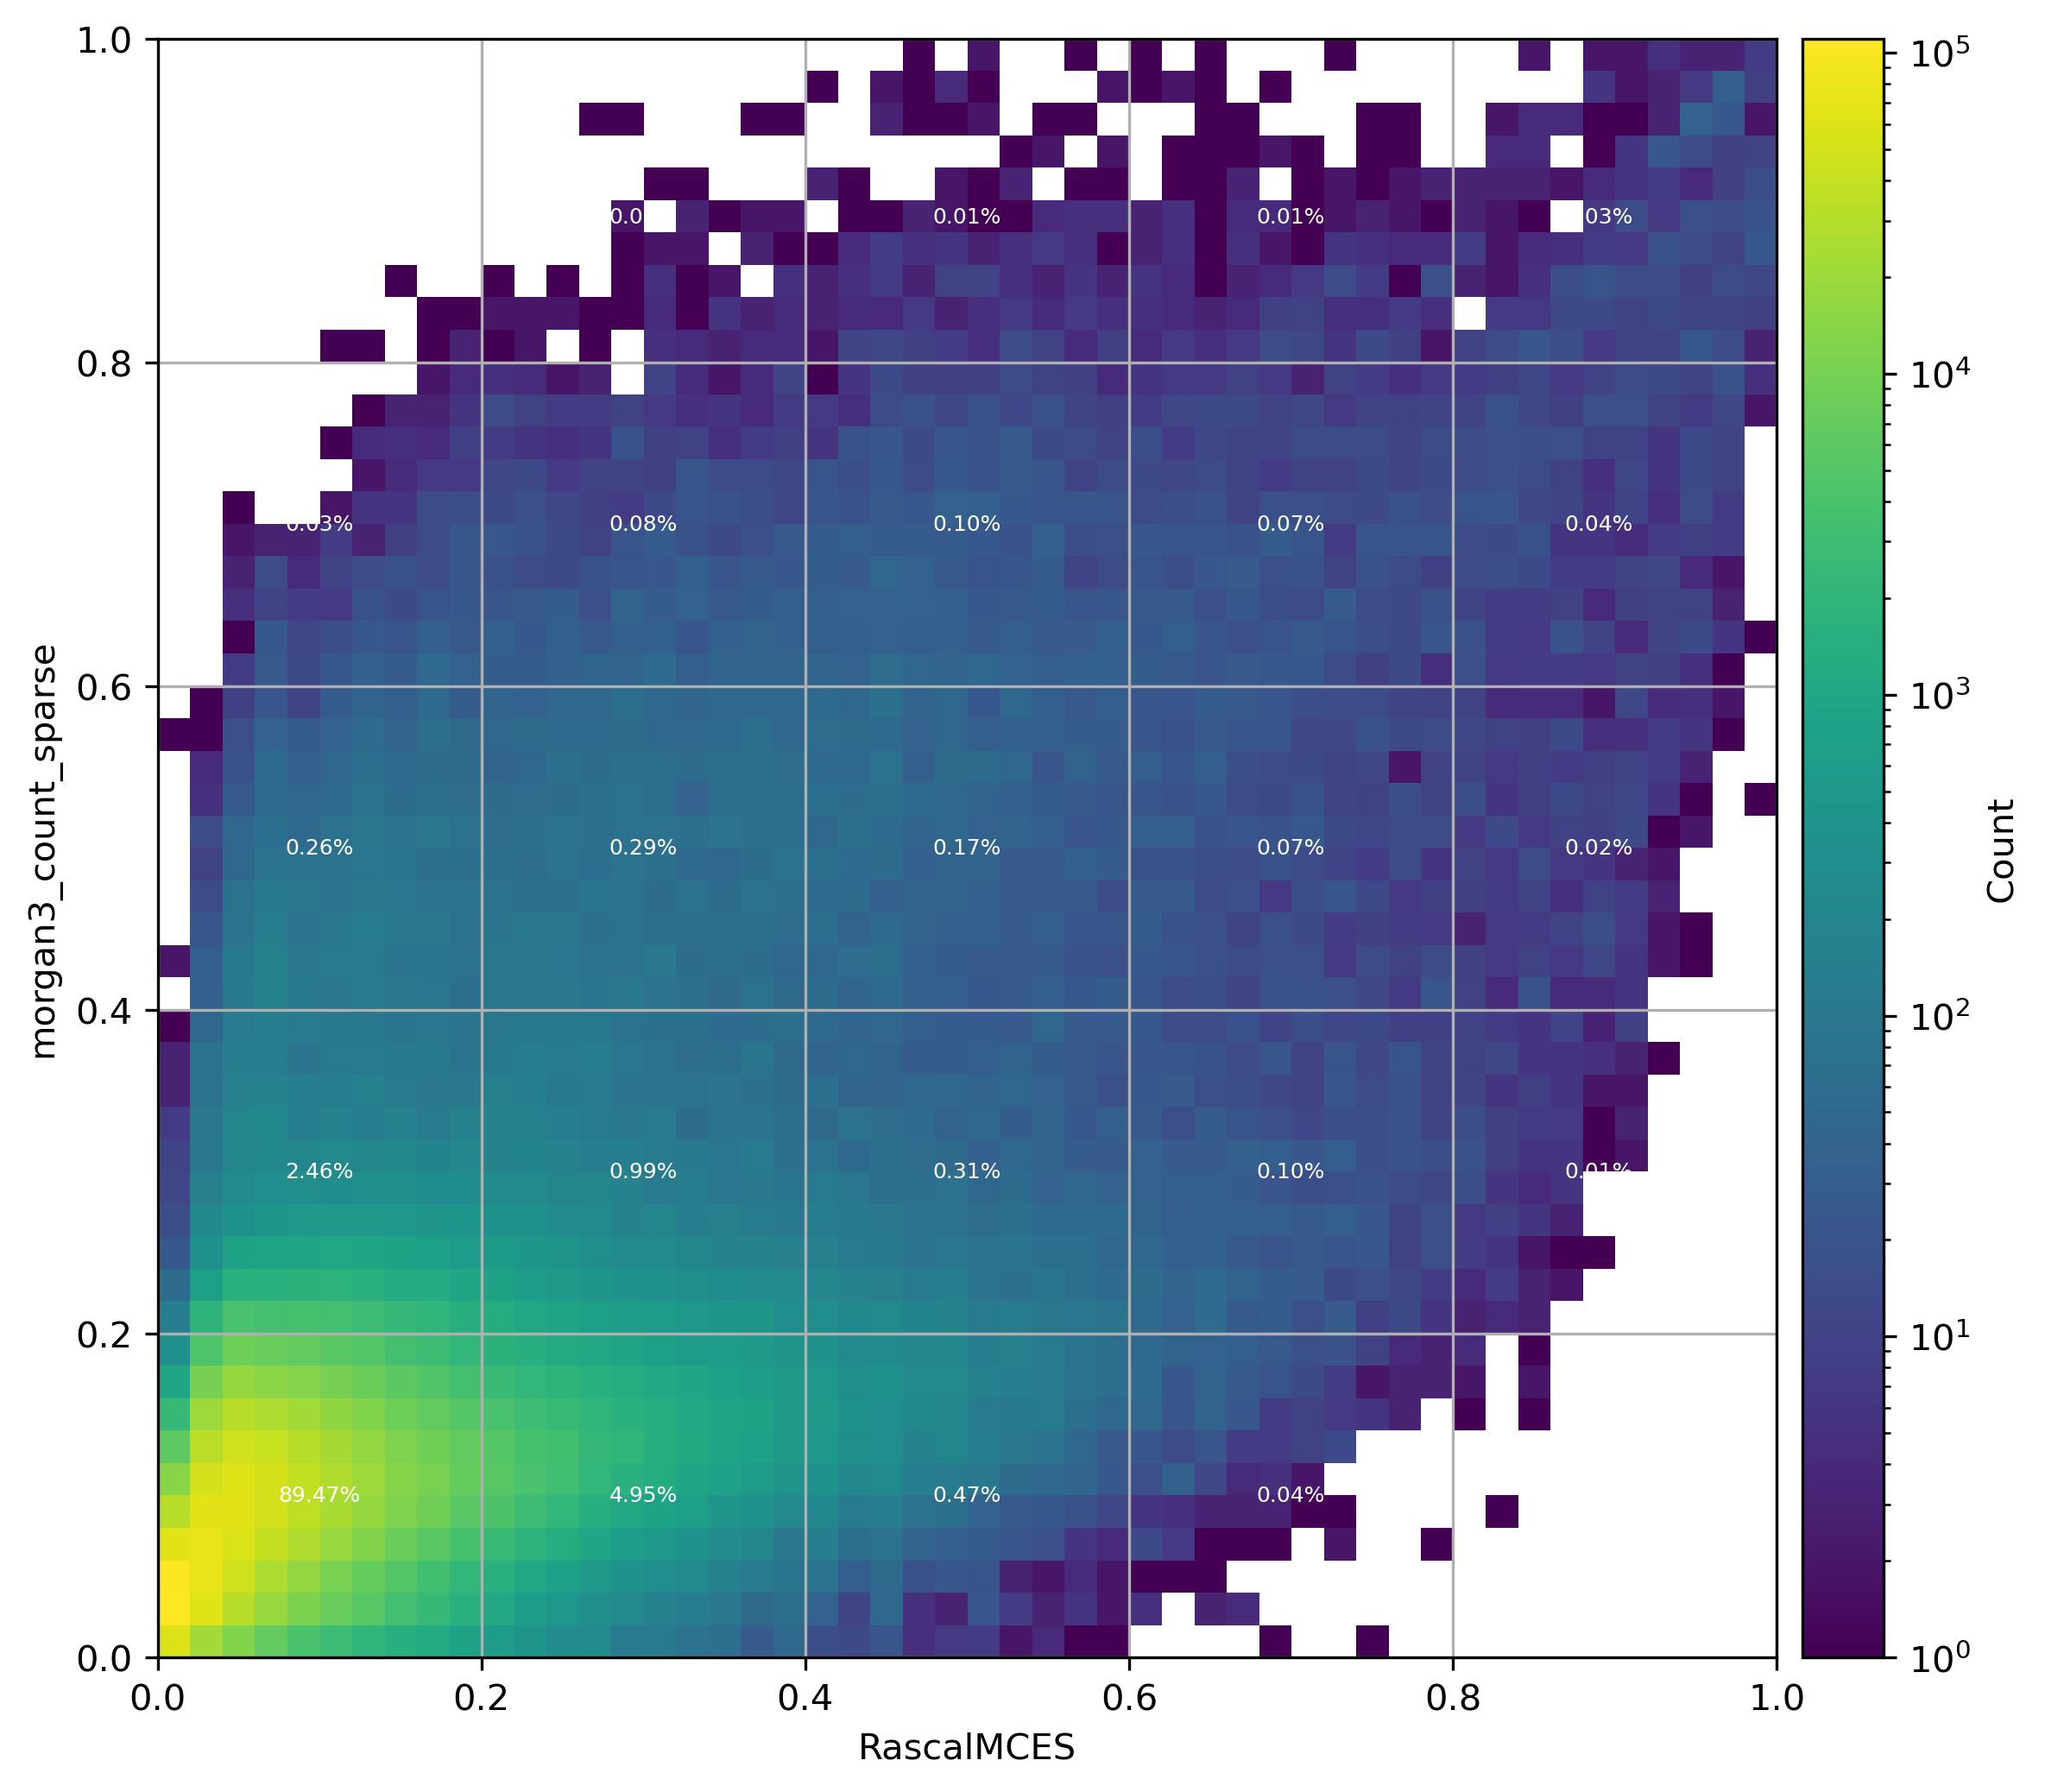

Pearson correlation between morgan3_count_sparse and rascalMCES: 0.57692
----- Experiment: morgan9_count_sparse -----


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37811/37811 [00:09<00:00, 4150.34it/s]


Collected 37811 sparse fingerprints.
Pearson correlation: 0.6506


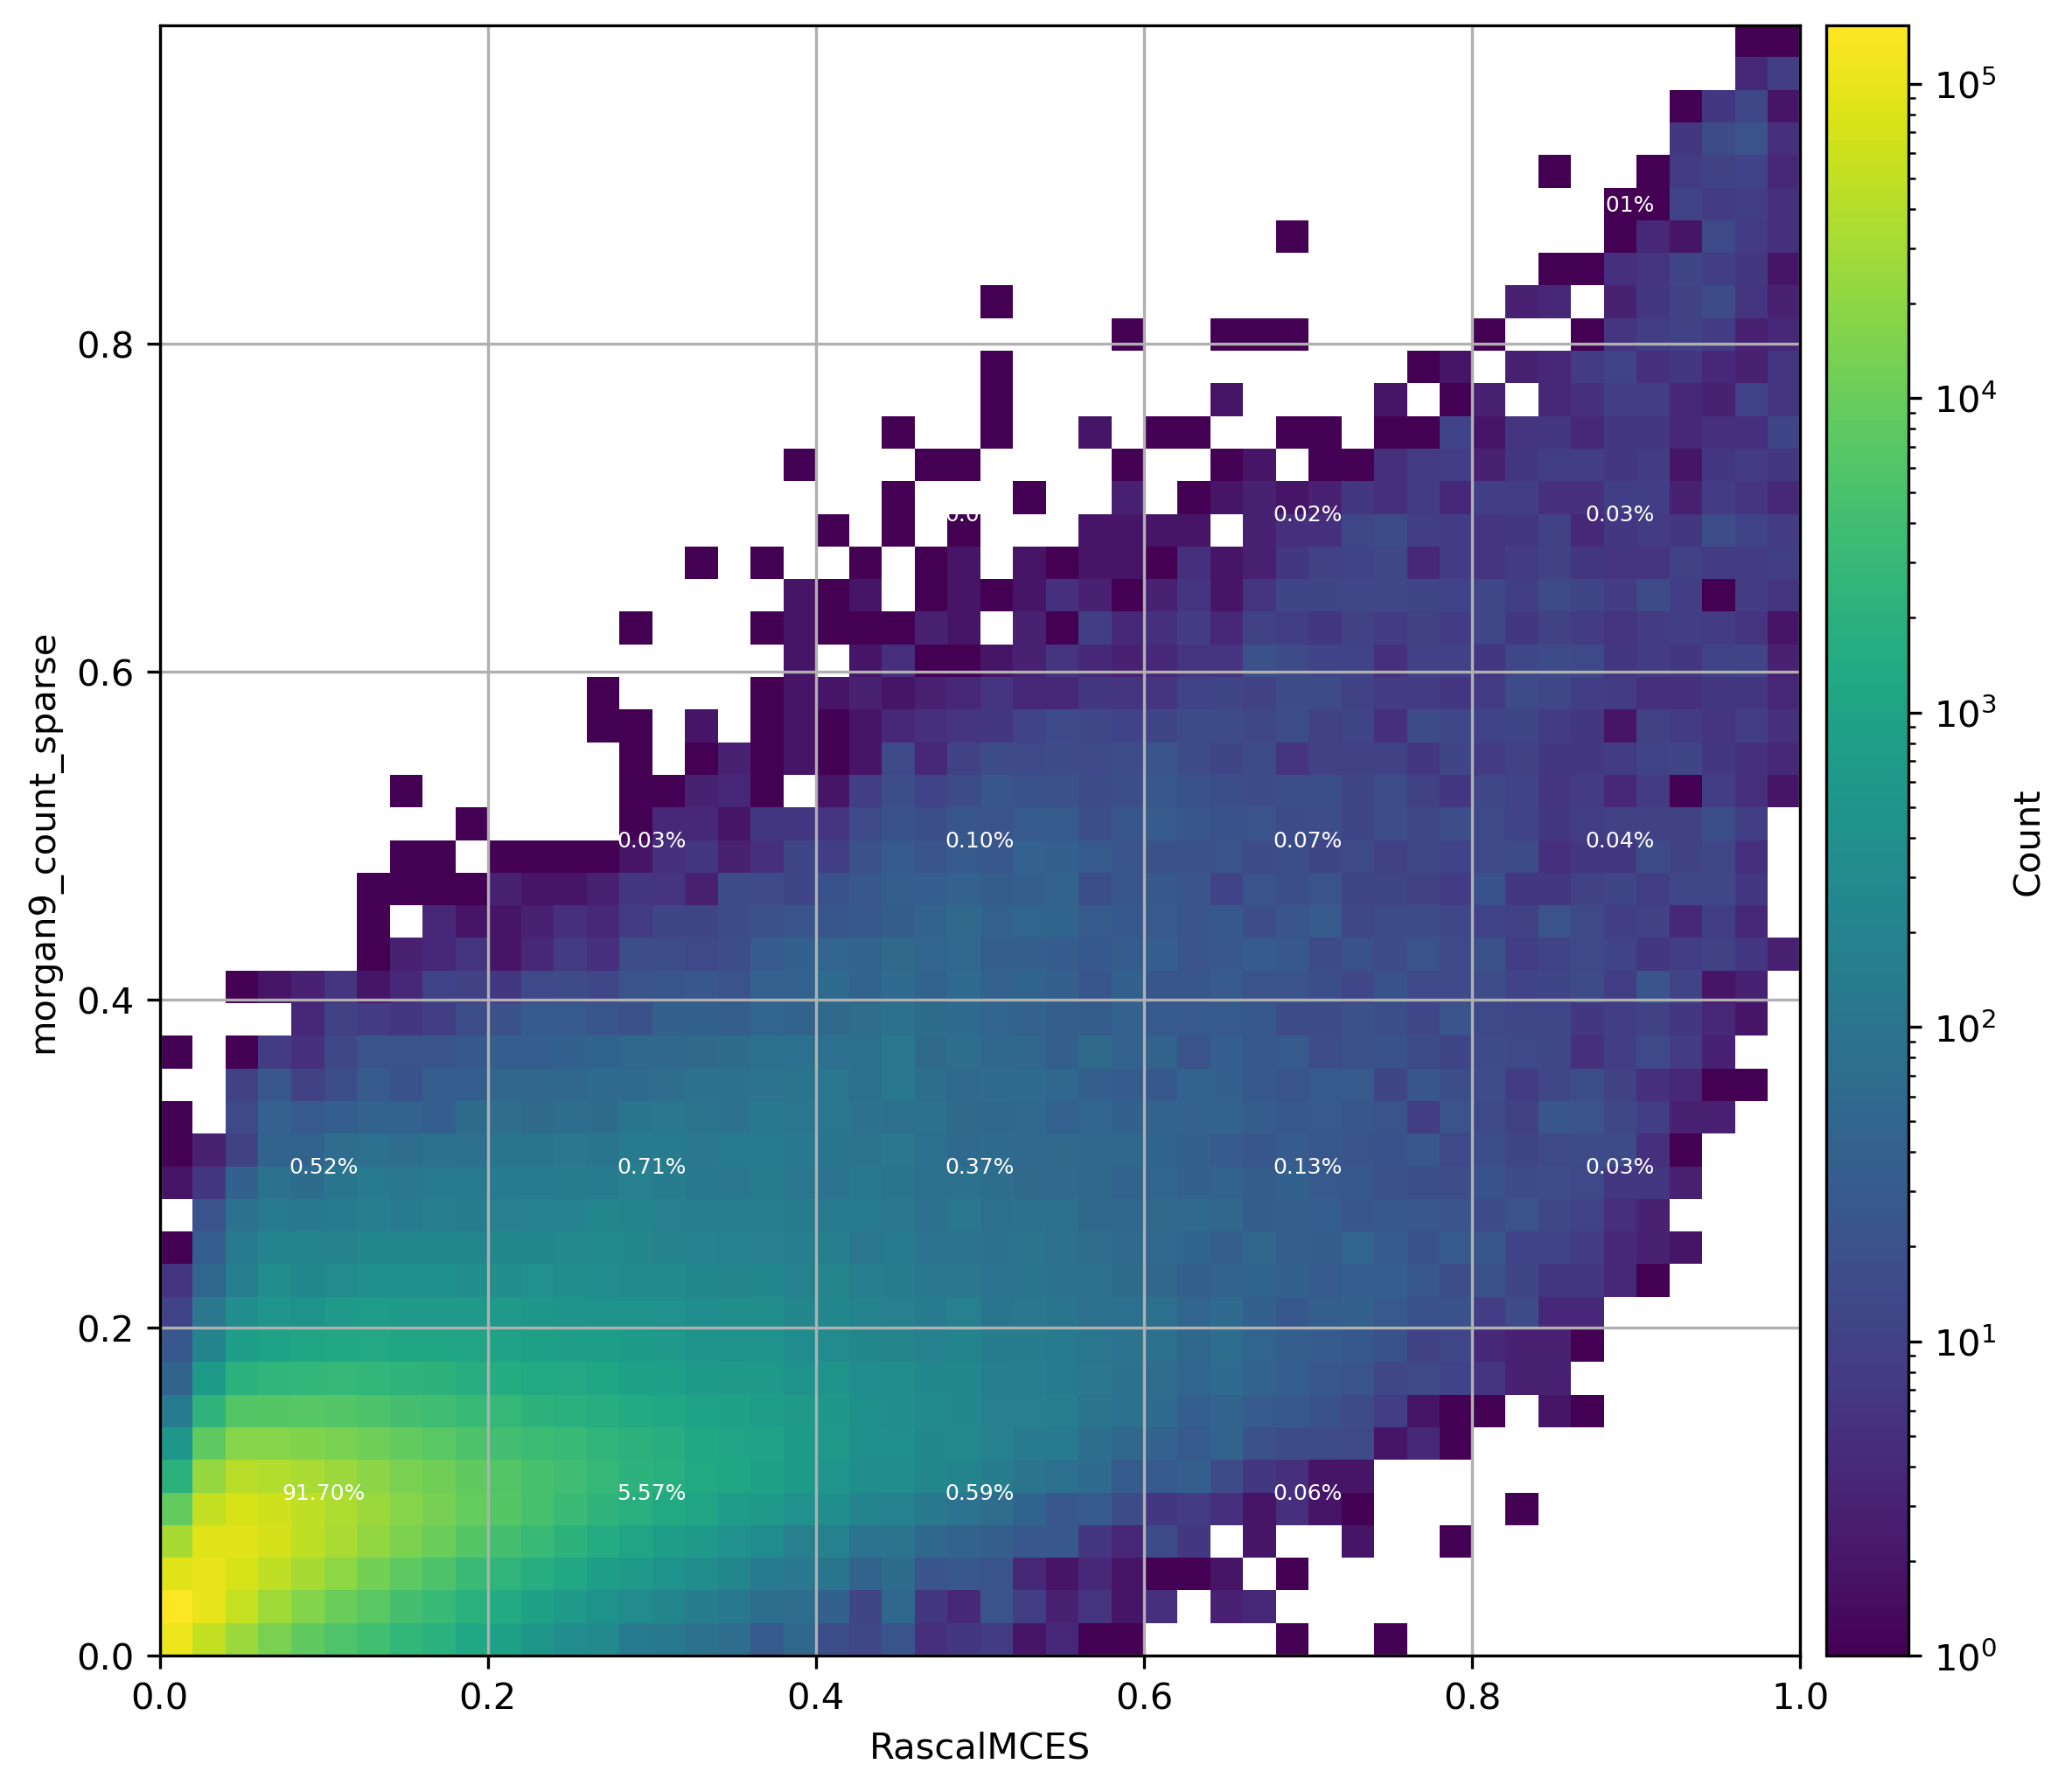

Pearson correlation between morgan9_count_sparse and rascalMCES: 0.65063
----- Experiment: morgan12_count_sparse -----


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37811/37811 [00:09<00:00, 3851.97it/s]


Collected 37811 sparse fingerprints.
Pearson correlation: 0.6515


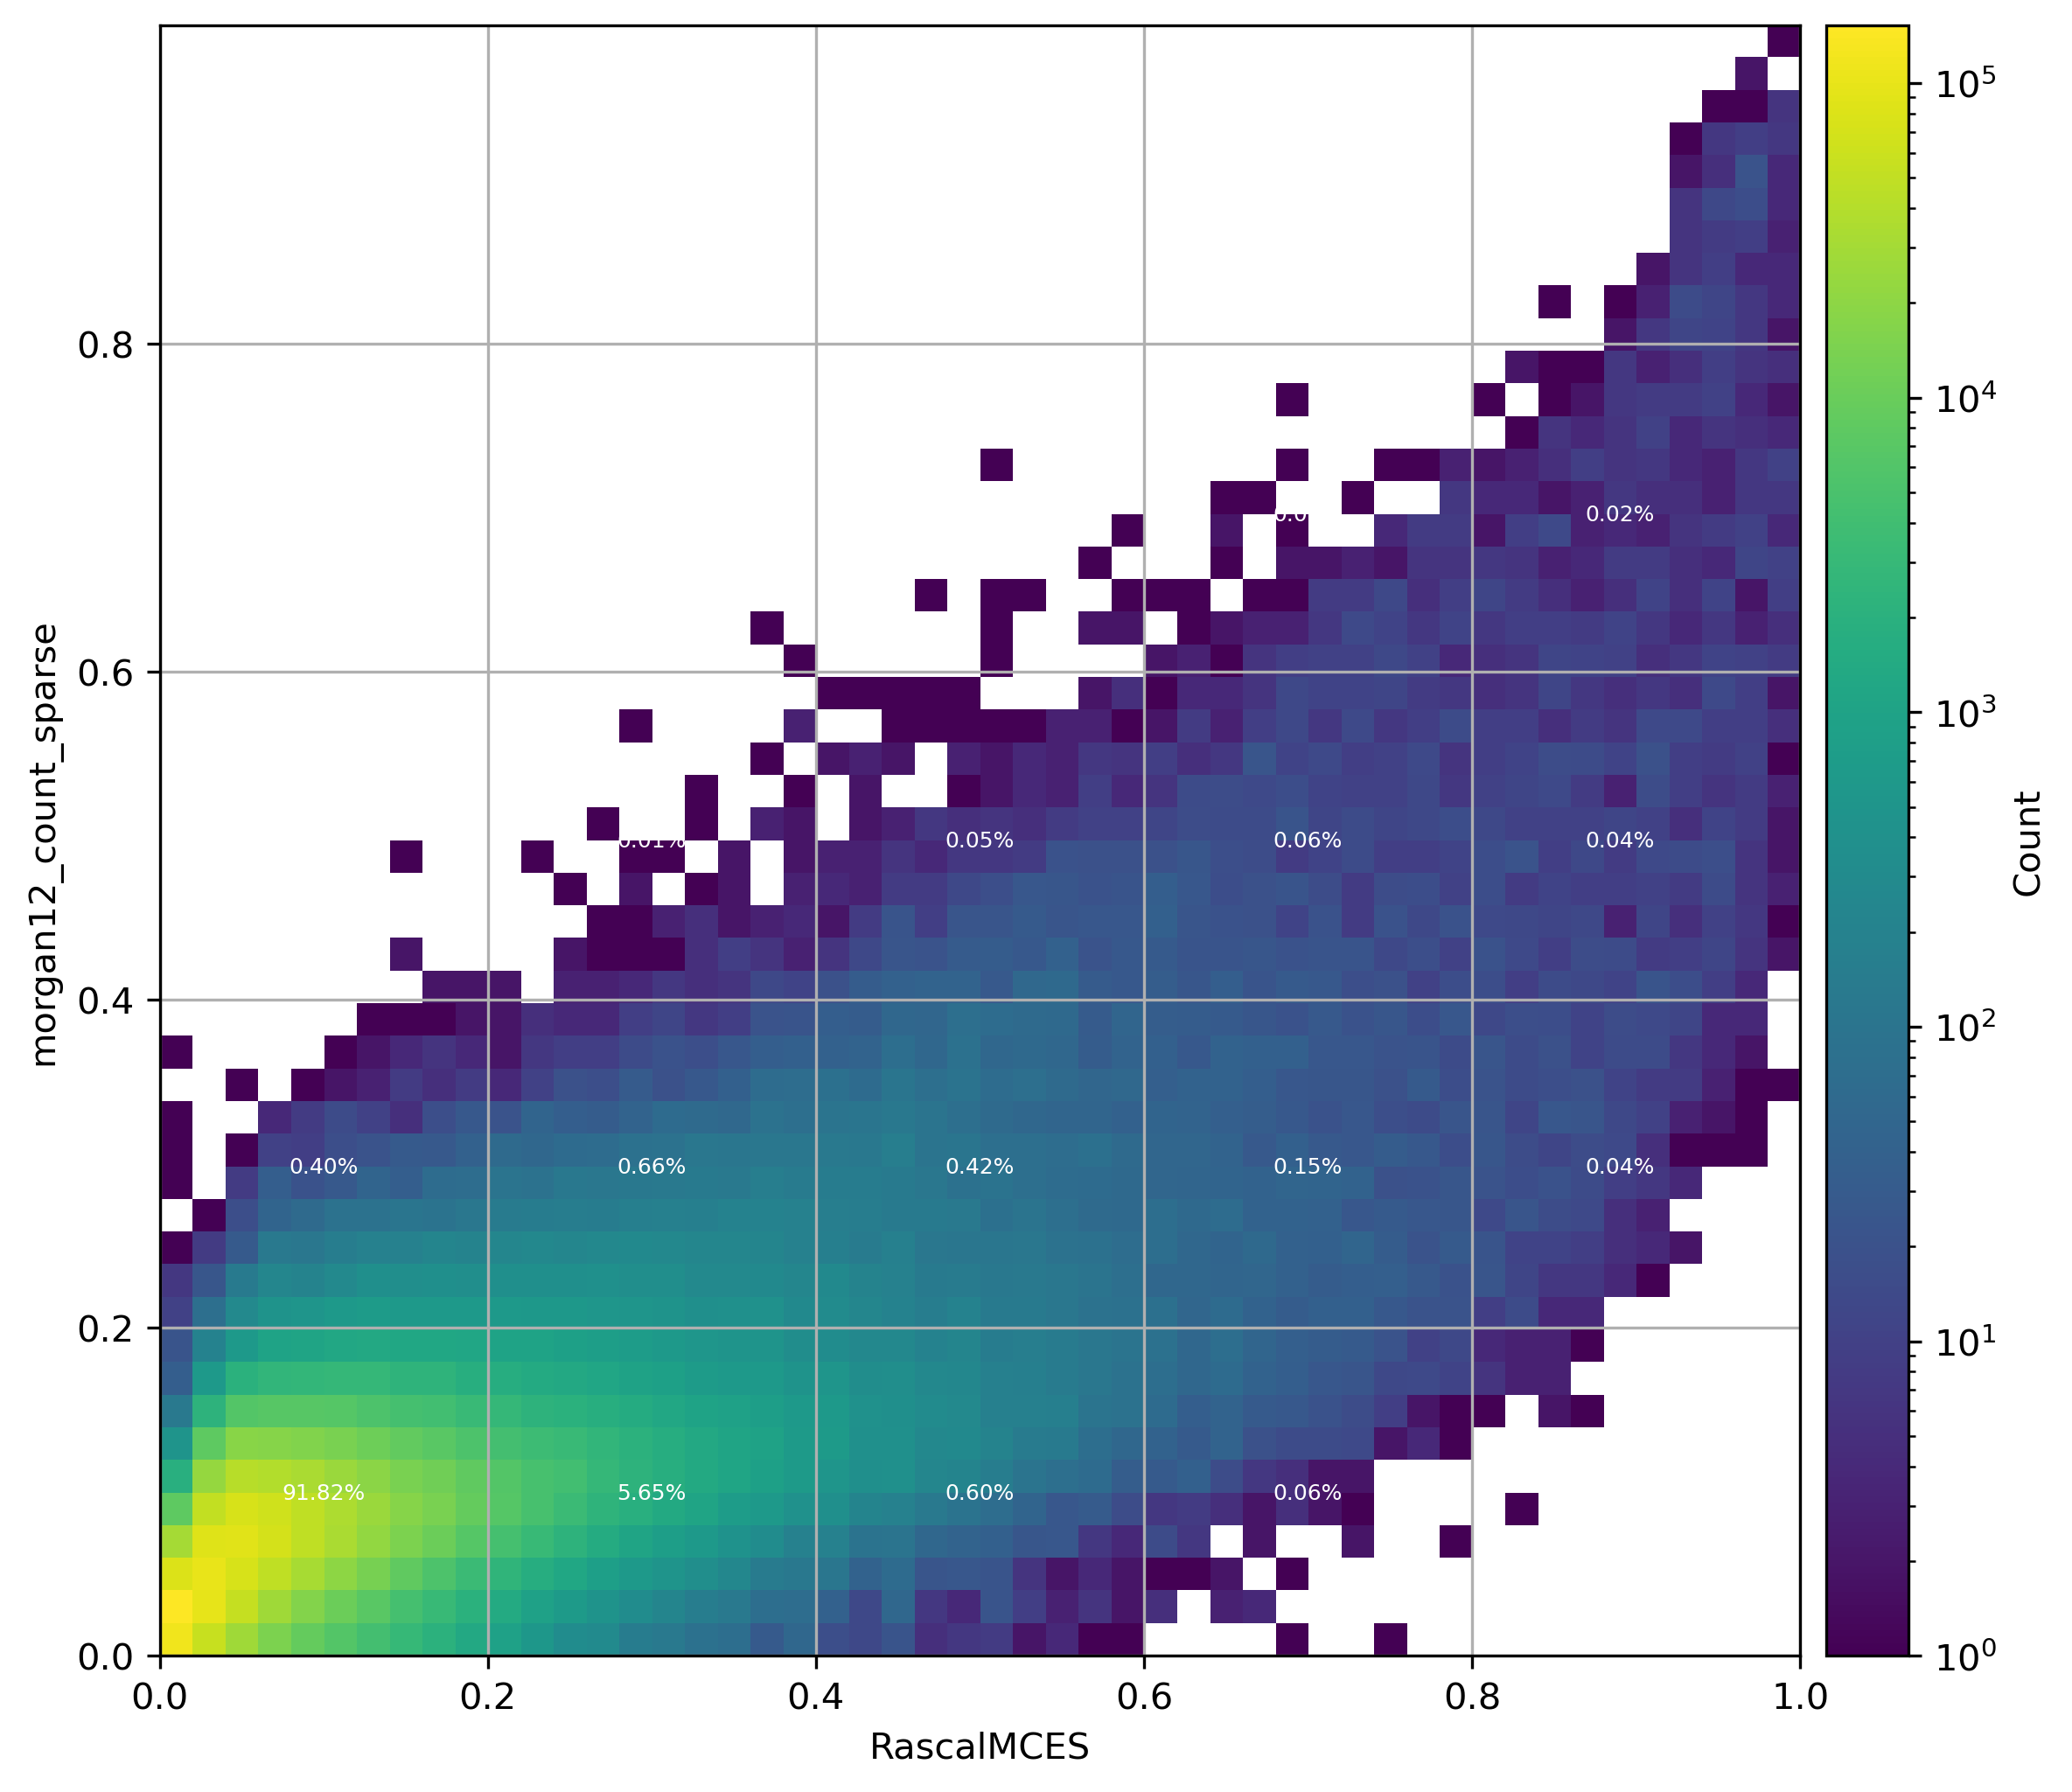

Pearson correlation between morgan12_count_sparse and rascalMCES: 0.65151
----- Experiment: morgan2_binary_sparse -----


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37811/37811 [00:04<00:00, 7798.33it/s]


Collected 37811 sparse fingerprints.
Pearson correlation: 0.5740


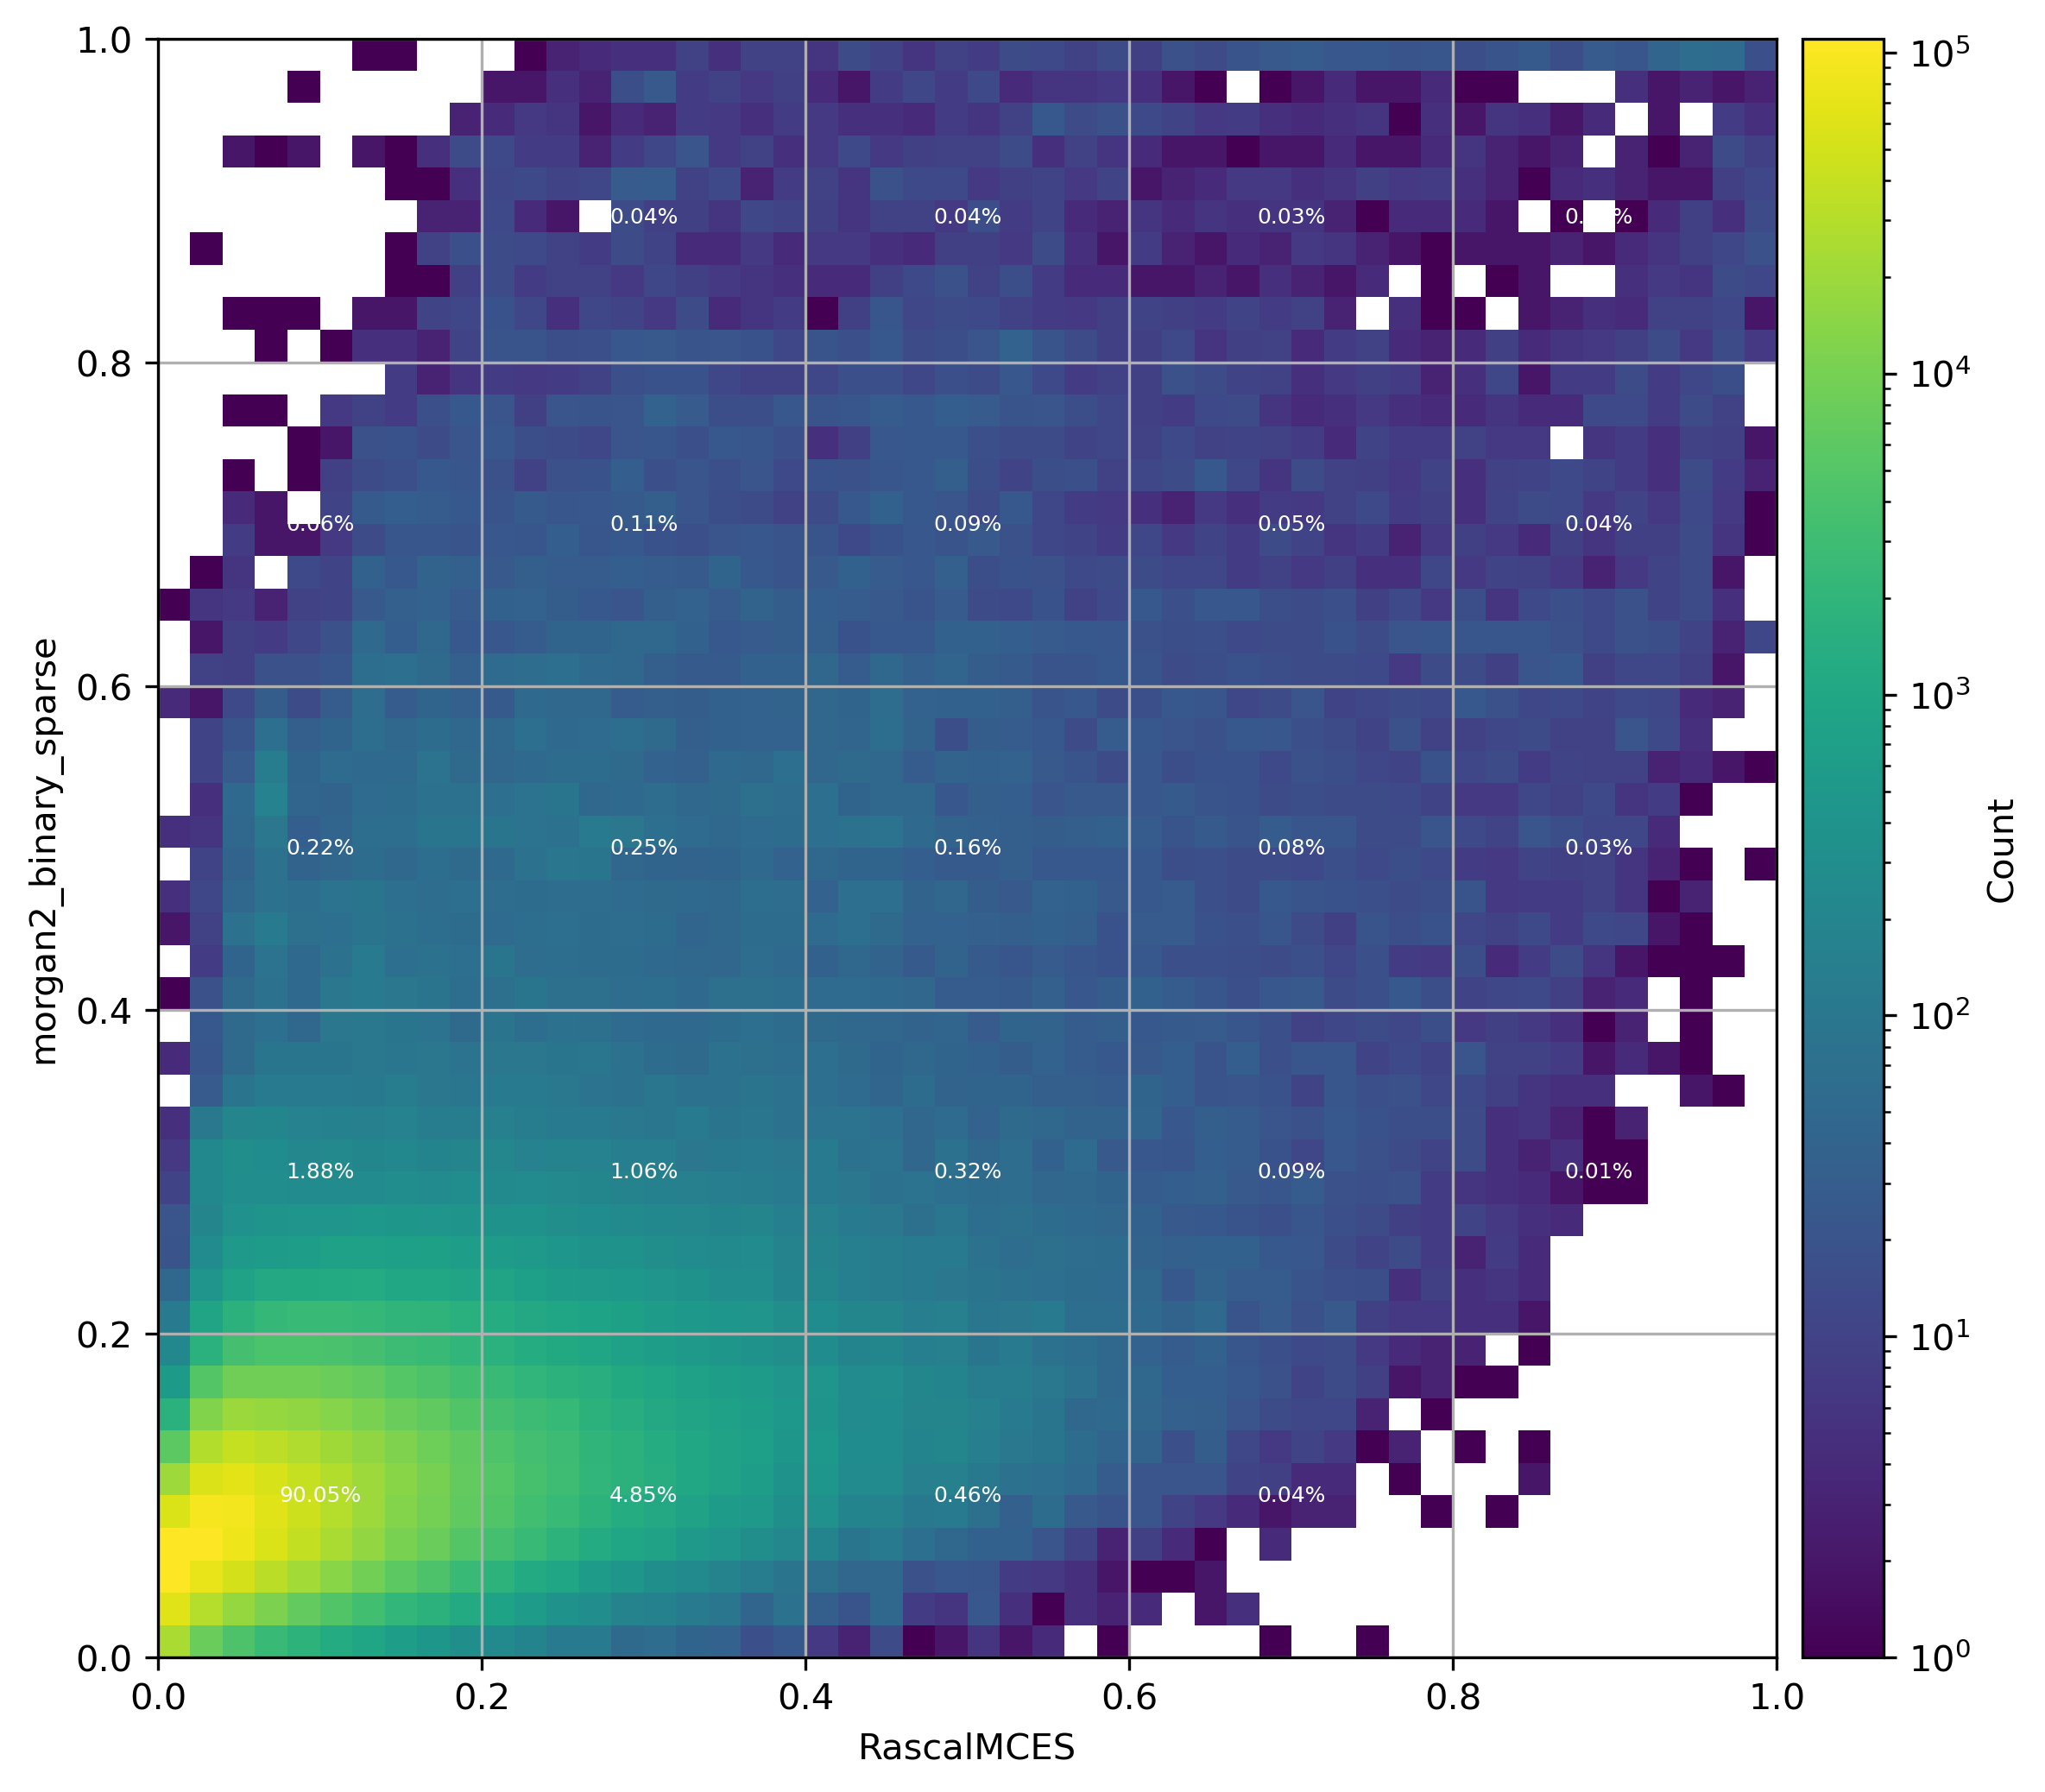

Pearson correlation between morgan2_binary_sparse and rascalMCES: 0.57401
----- Experiment: morgan3_binary_sparse -----


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37811/37811 [00:05<00:00, 6677.02it/s]


Collected 37811 sparse fingerprints.
Pearson correlation: 0.5792


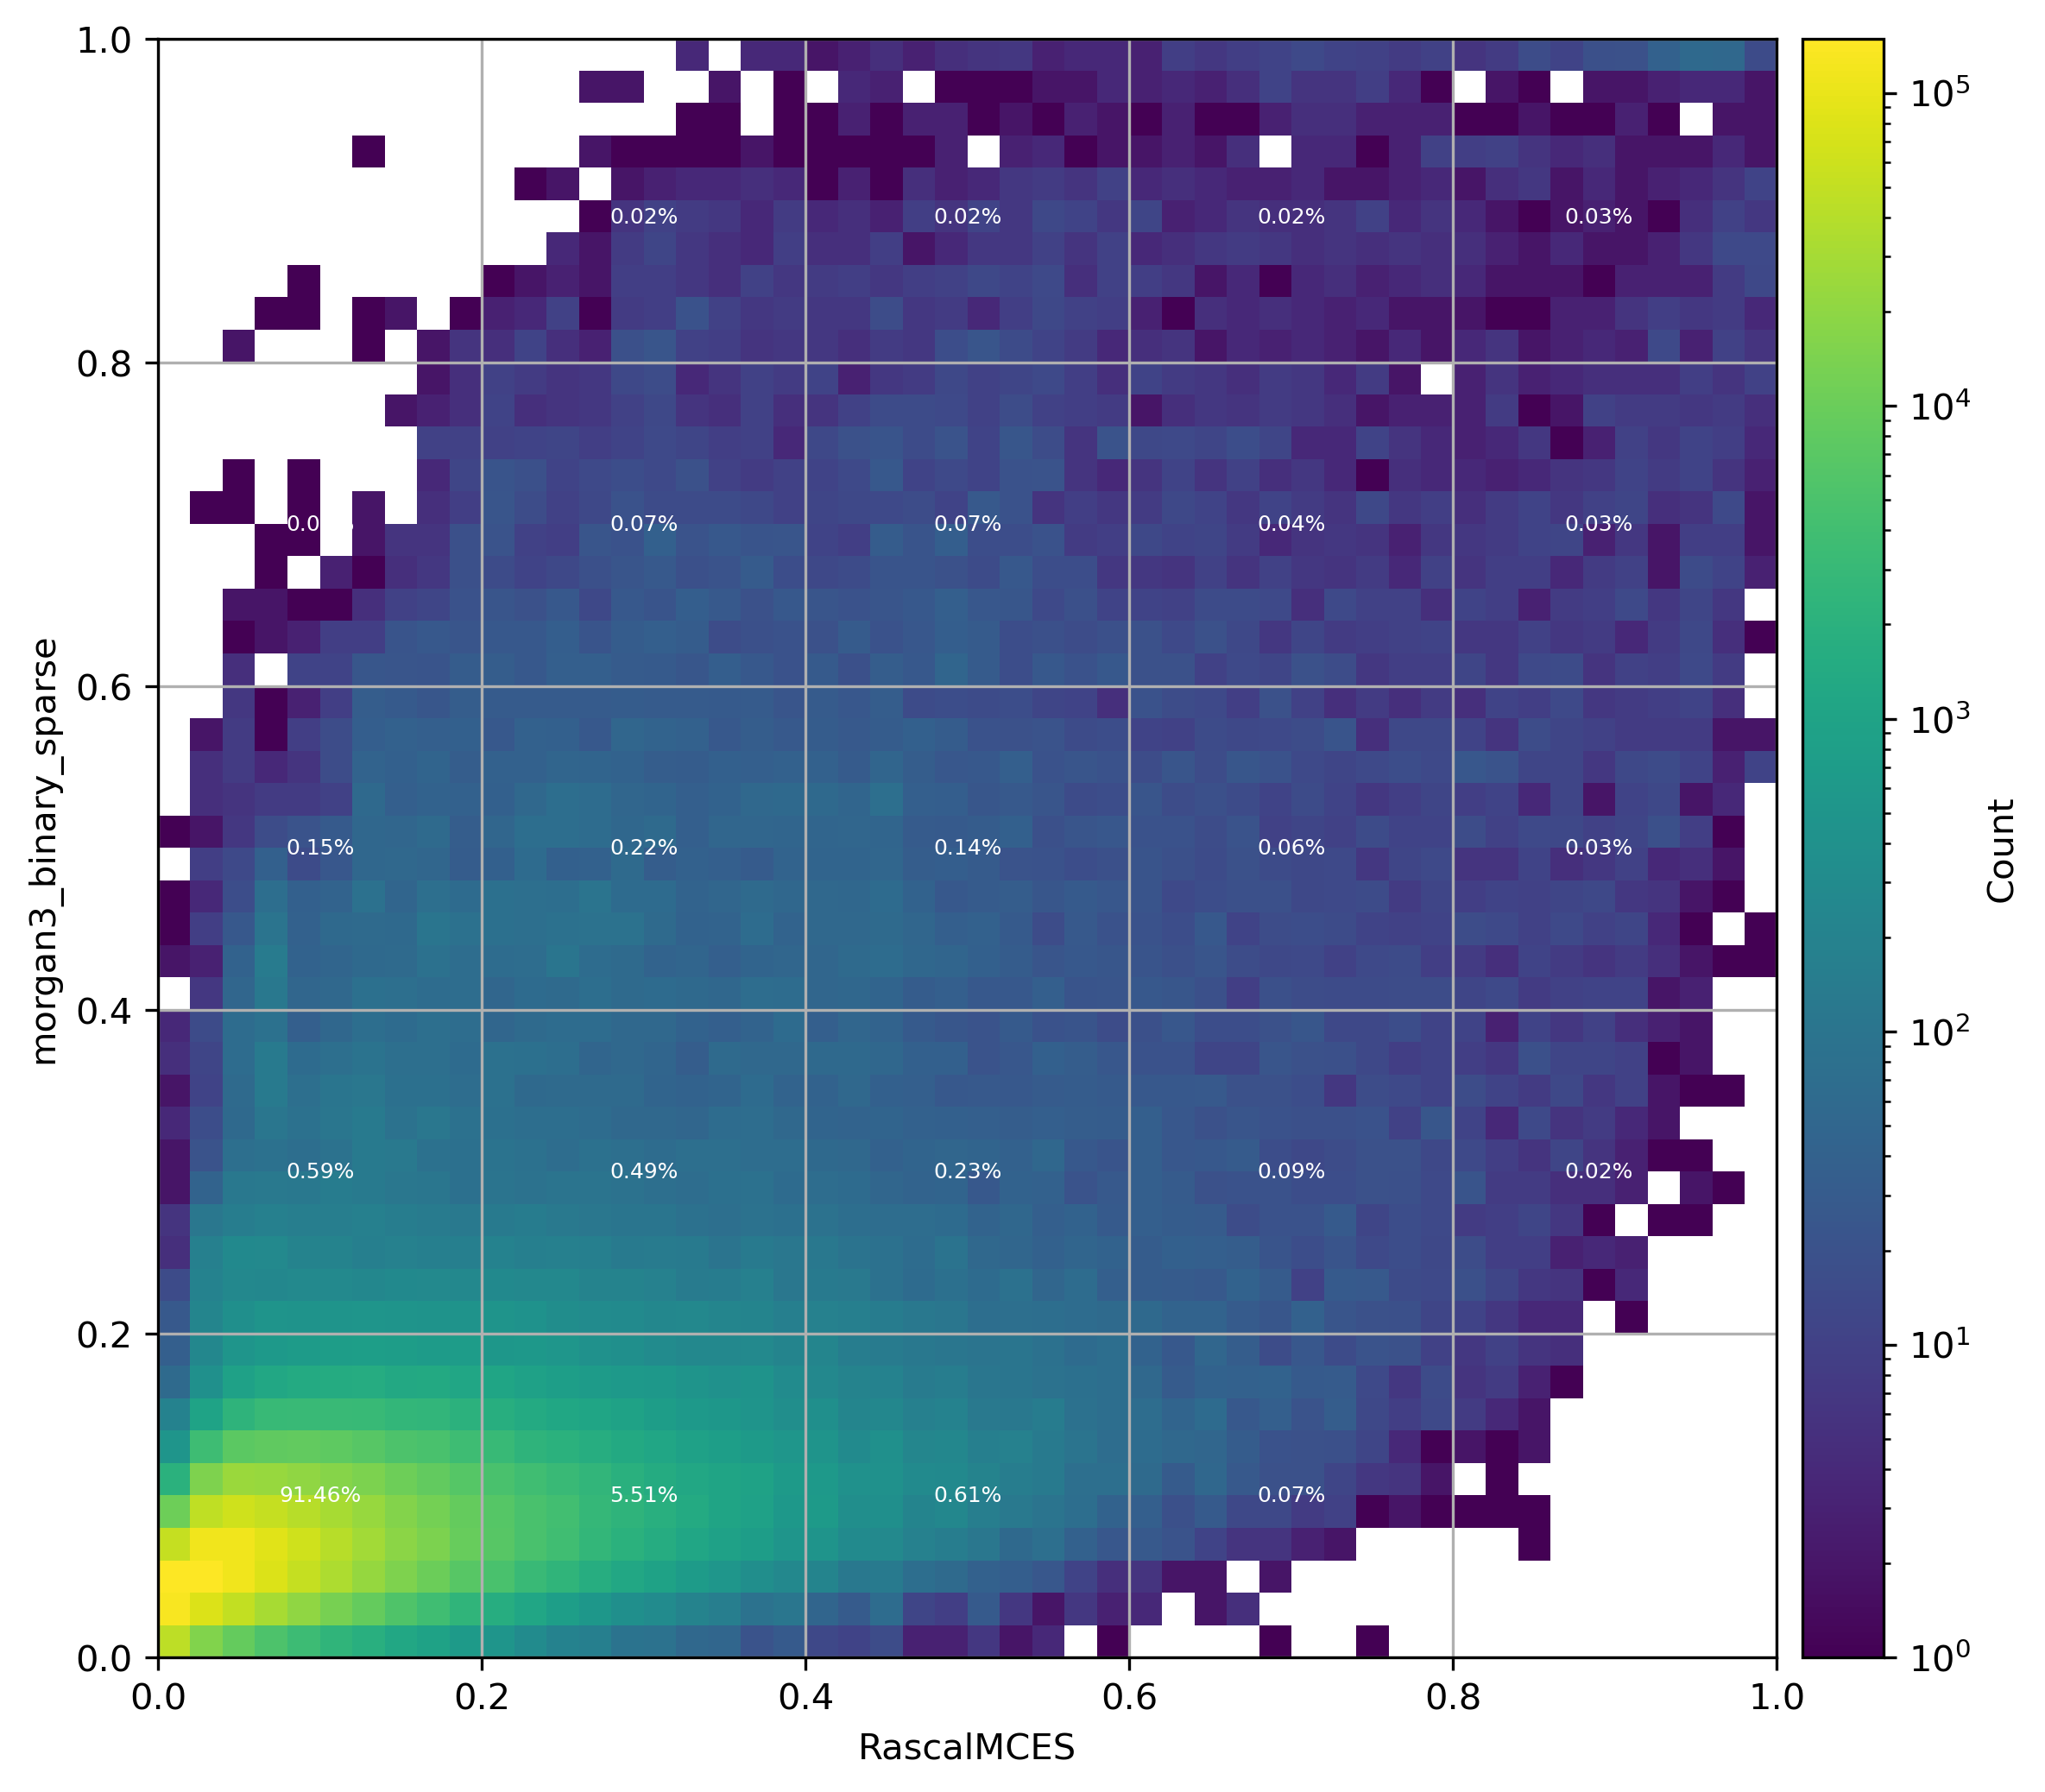

Pearson correlation between morgan3_binary_sparse and rascalMCES: 0.57924
----- Experiment: rdkit_sparse -----


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37811/37811 [00:41<00:00, 912.56it/s]


Collected 37811 sparse fingerprints.
Pearson correlation: 0.6482


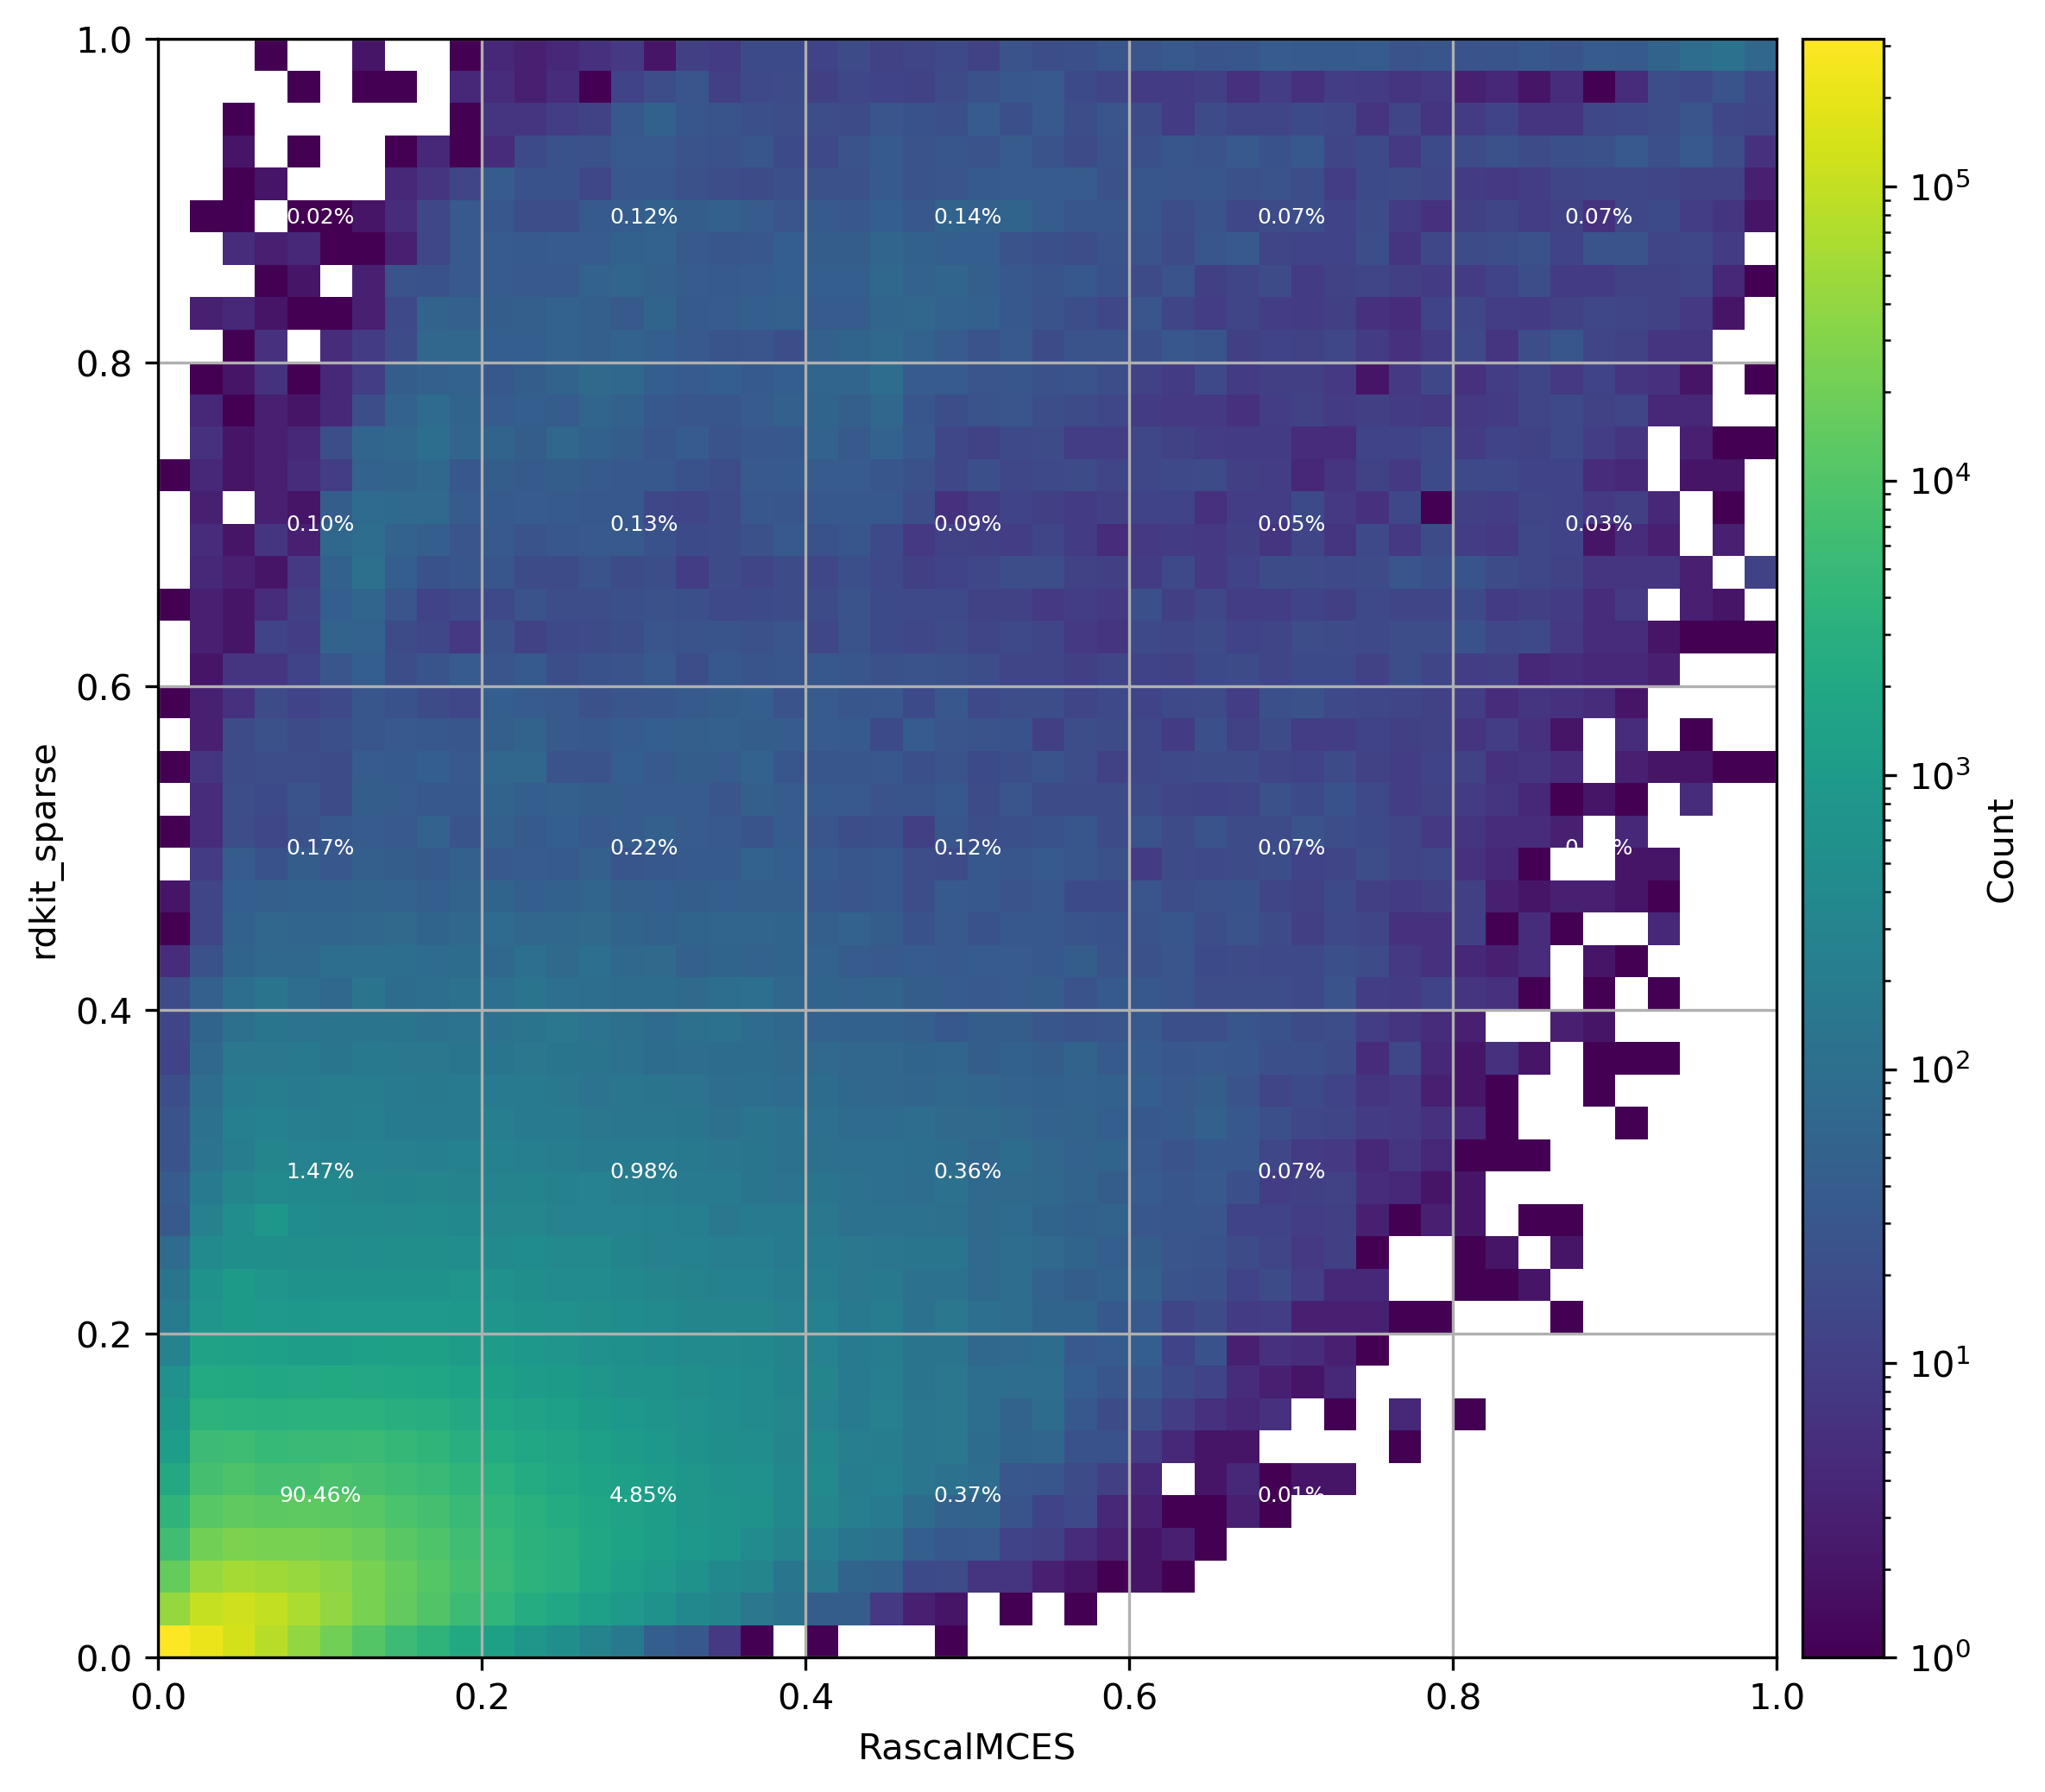

Pearson correlation between rdkit_sparse and rascalMCES: 0.64816
----- Experiment: map2_sparse -----


  0%|          | 0/37811 [00:00<?, ?it/s]

Collected 37811 sparse fingerprints.
Pearson correlation: 0.6010


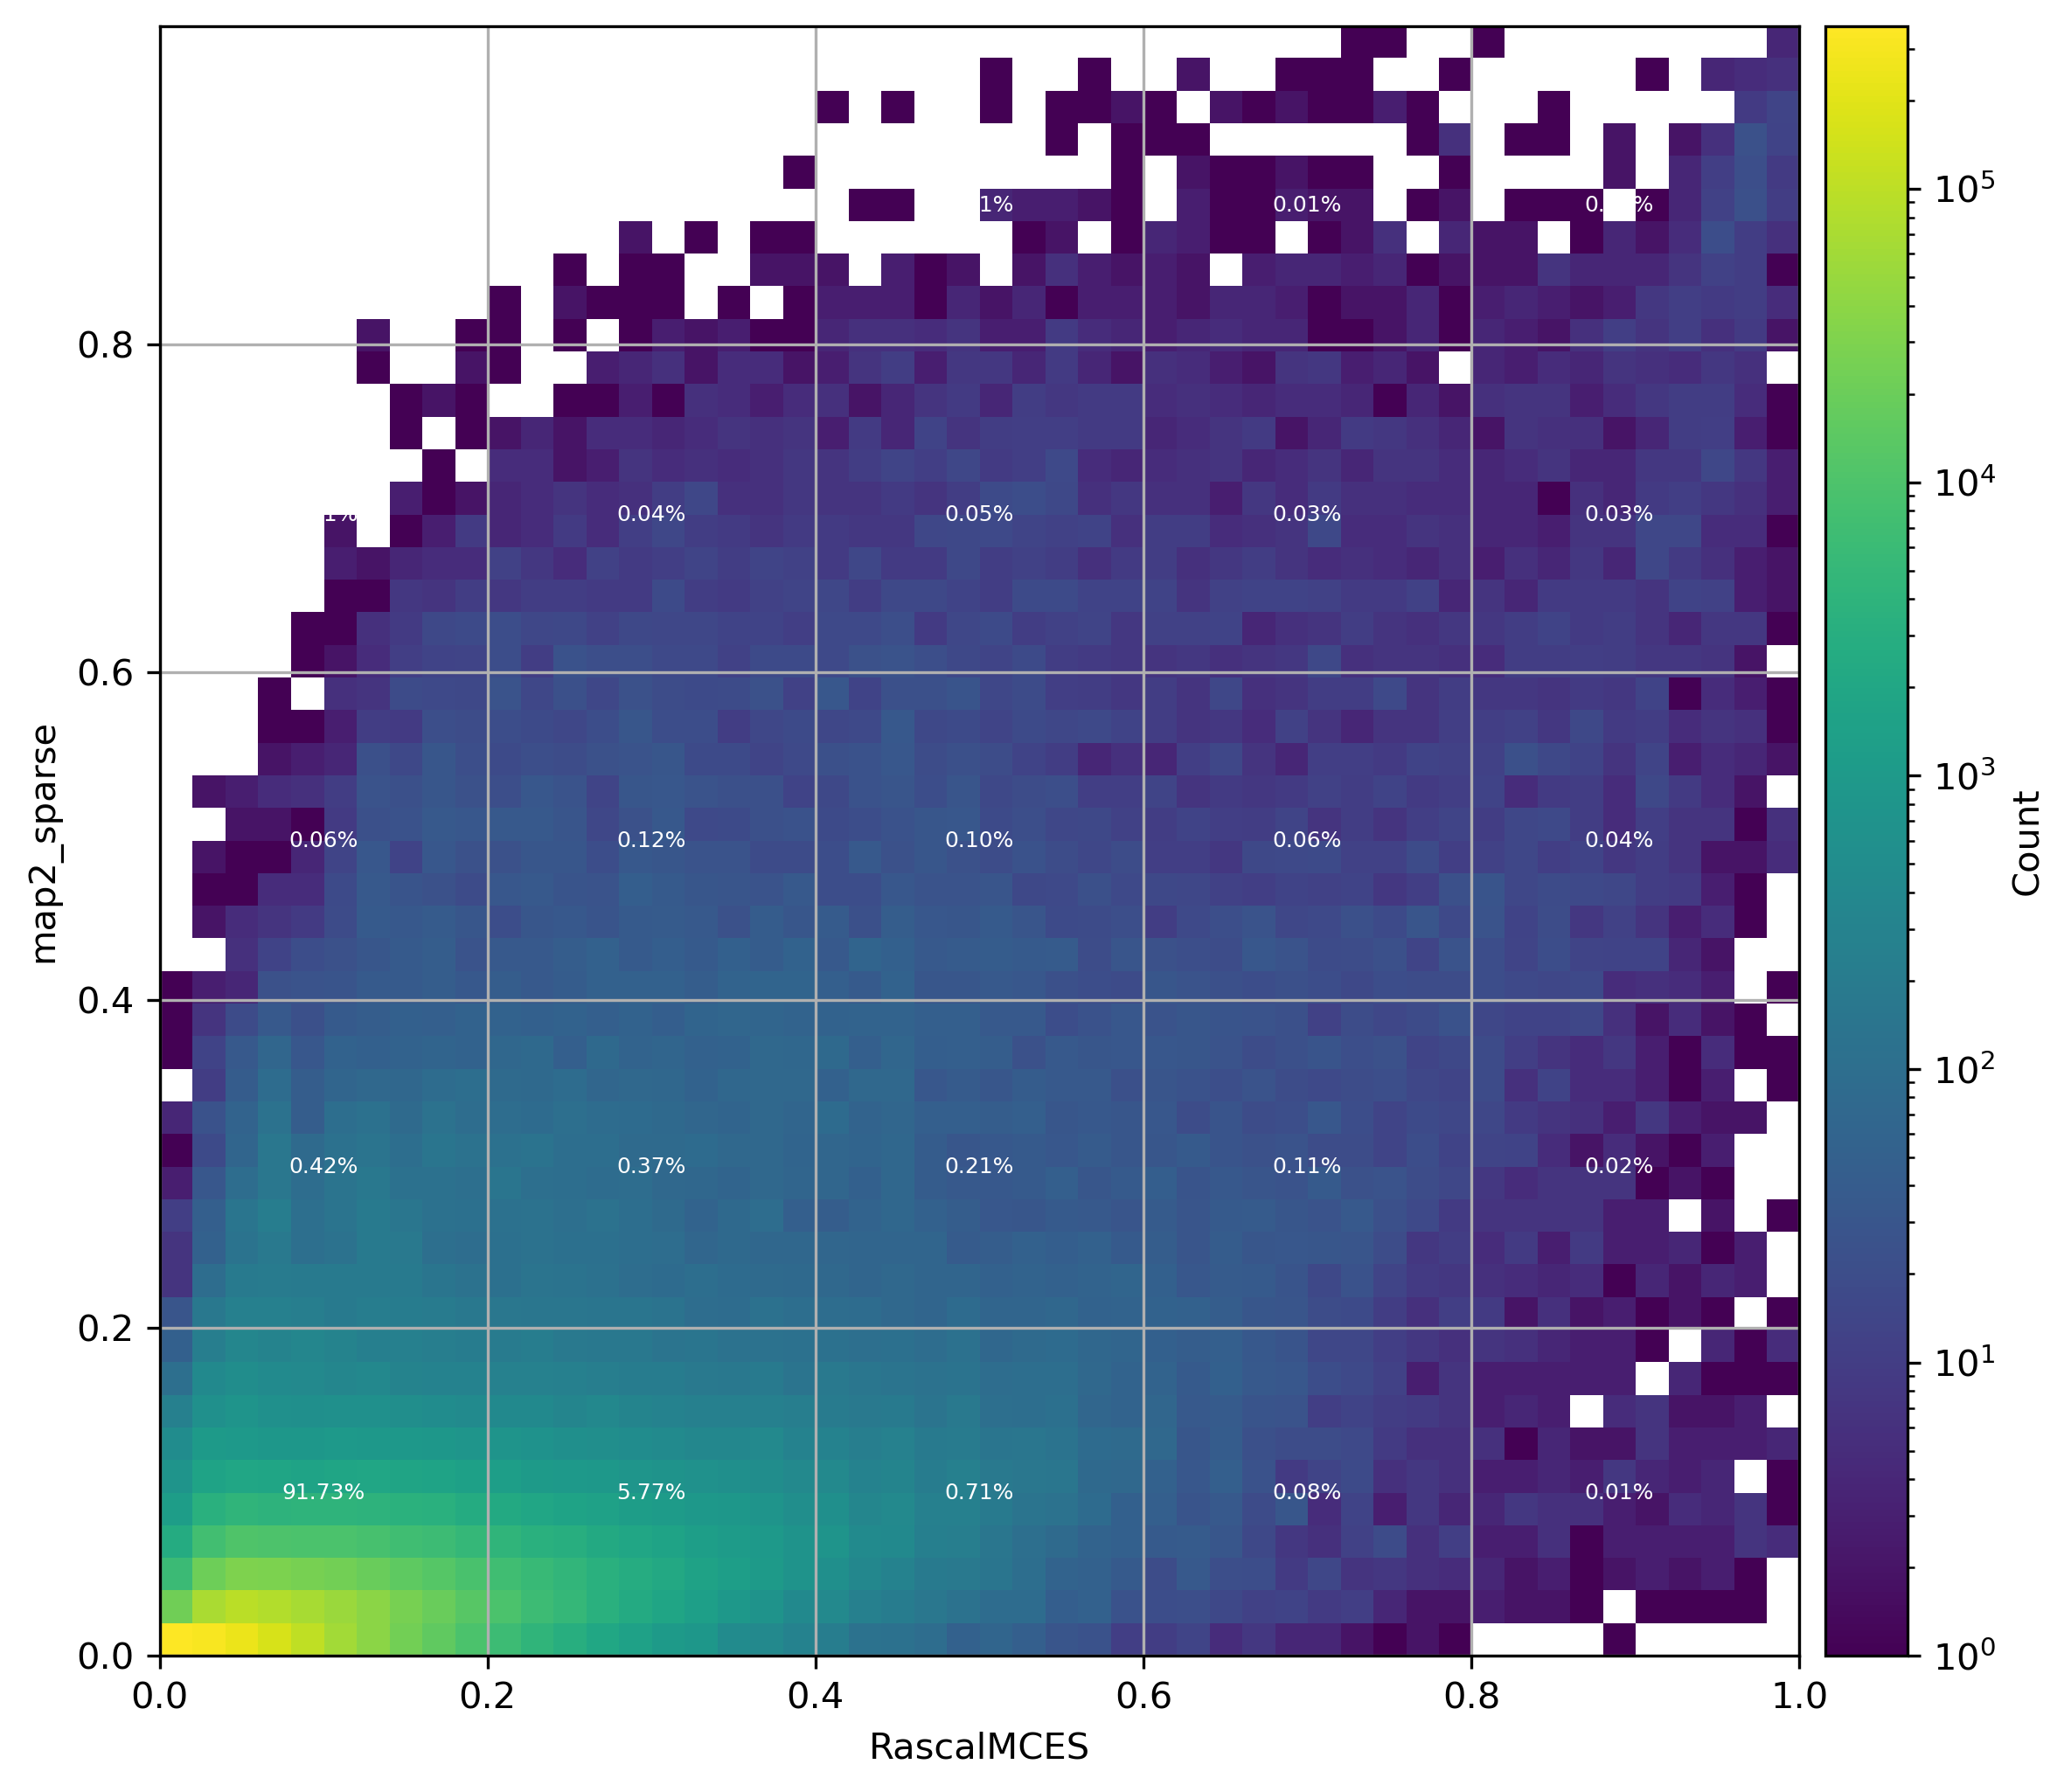

Pearson correlation between map2_sparse and rascalMCES: 0.60102
----- Experiment: map4_sparse -----


  0%|          | 0/37811 [00:00<?, ?it/s]

Collected 37811 sparse fingerprints.
Pearson correlation: 0.5719


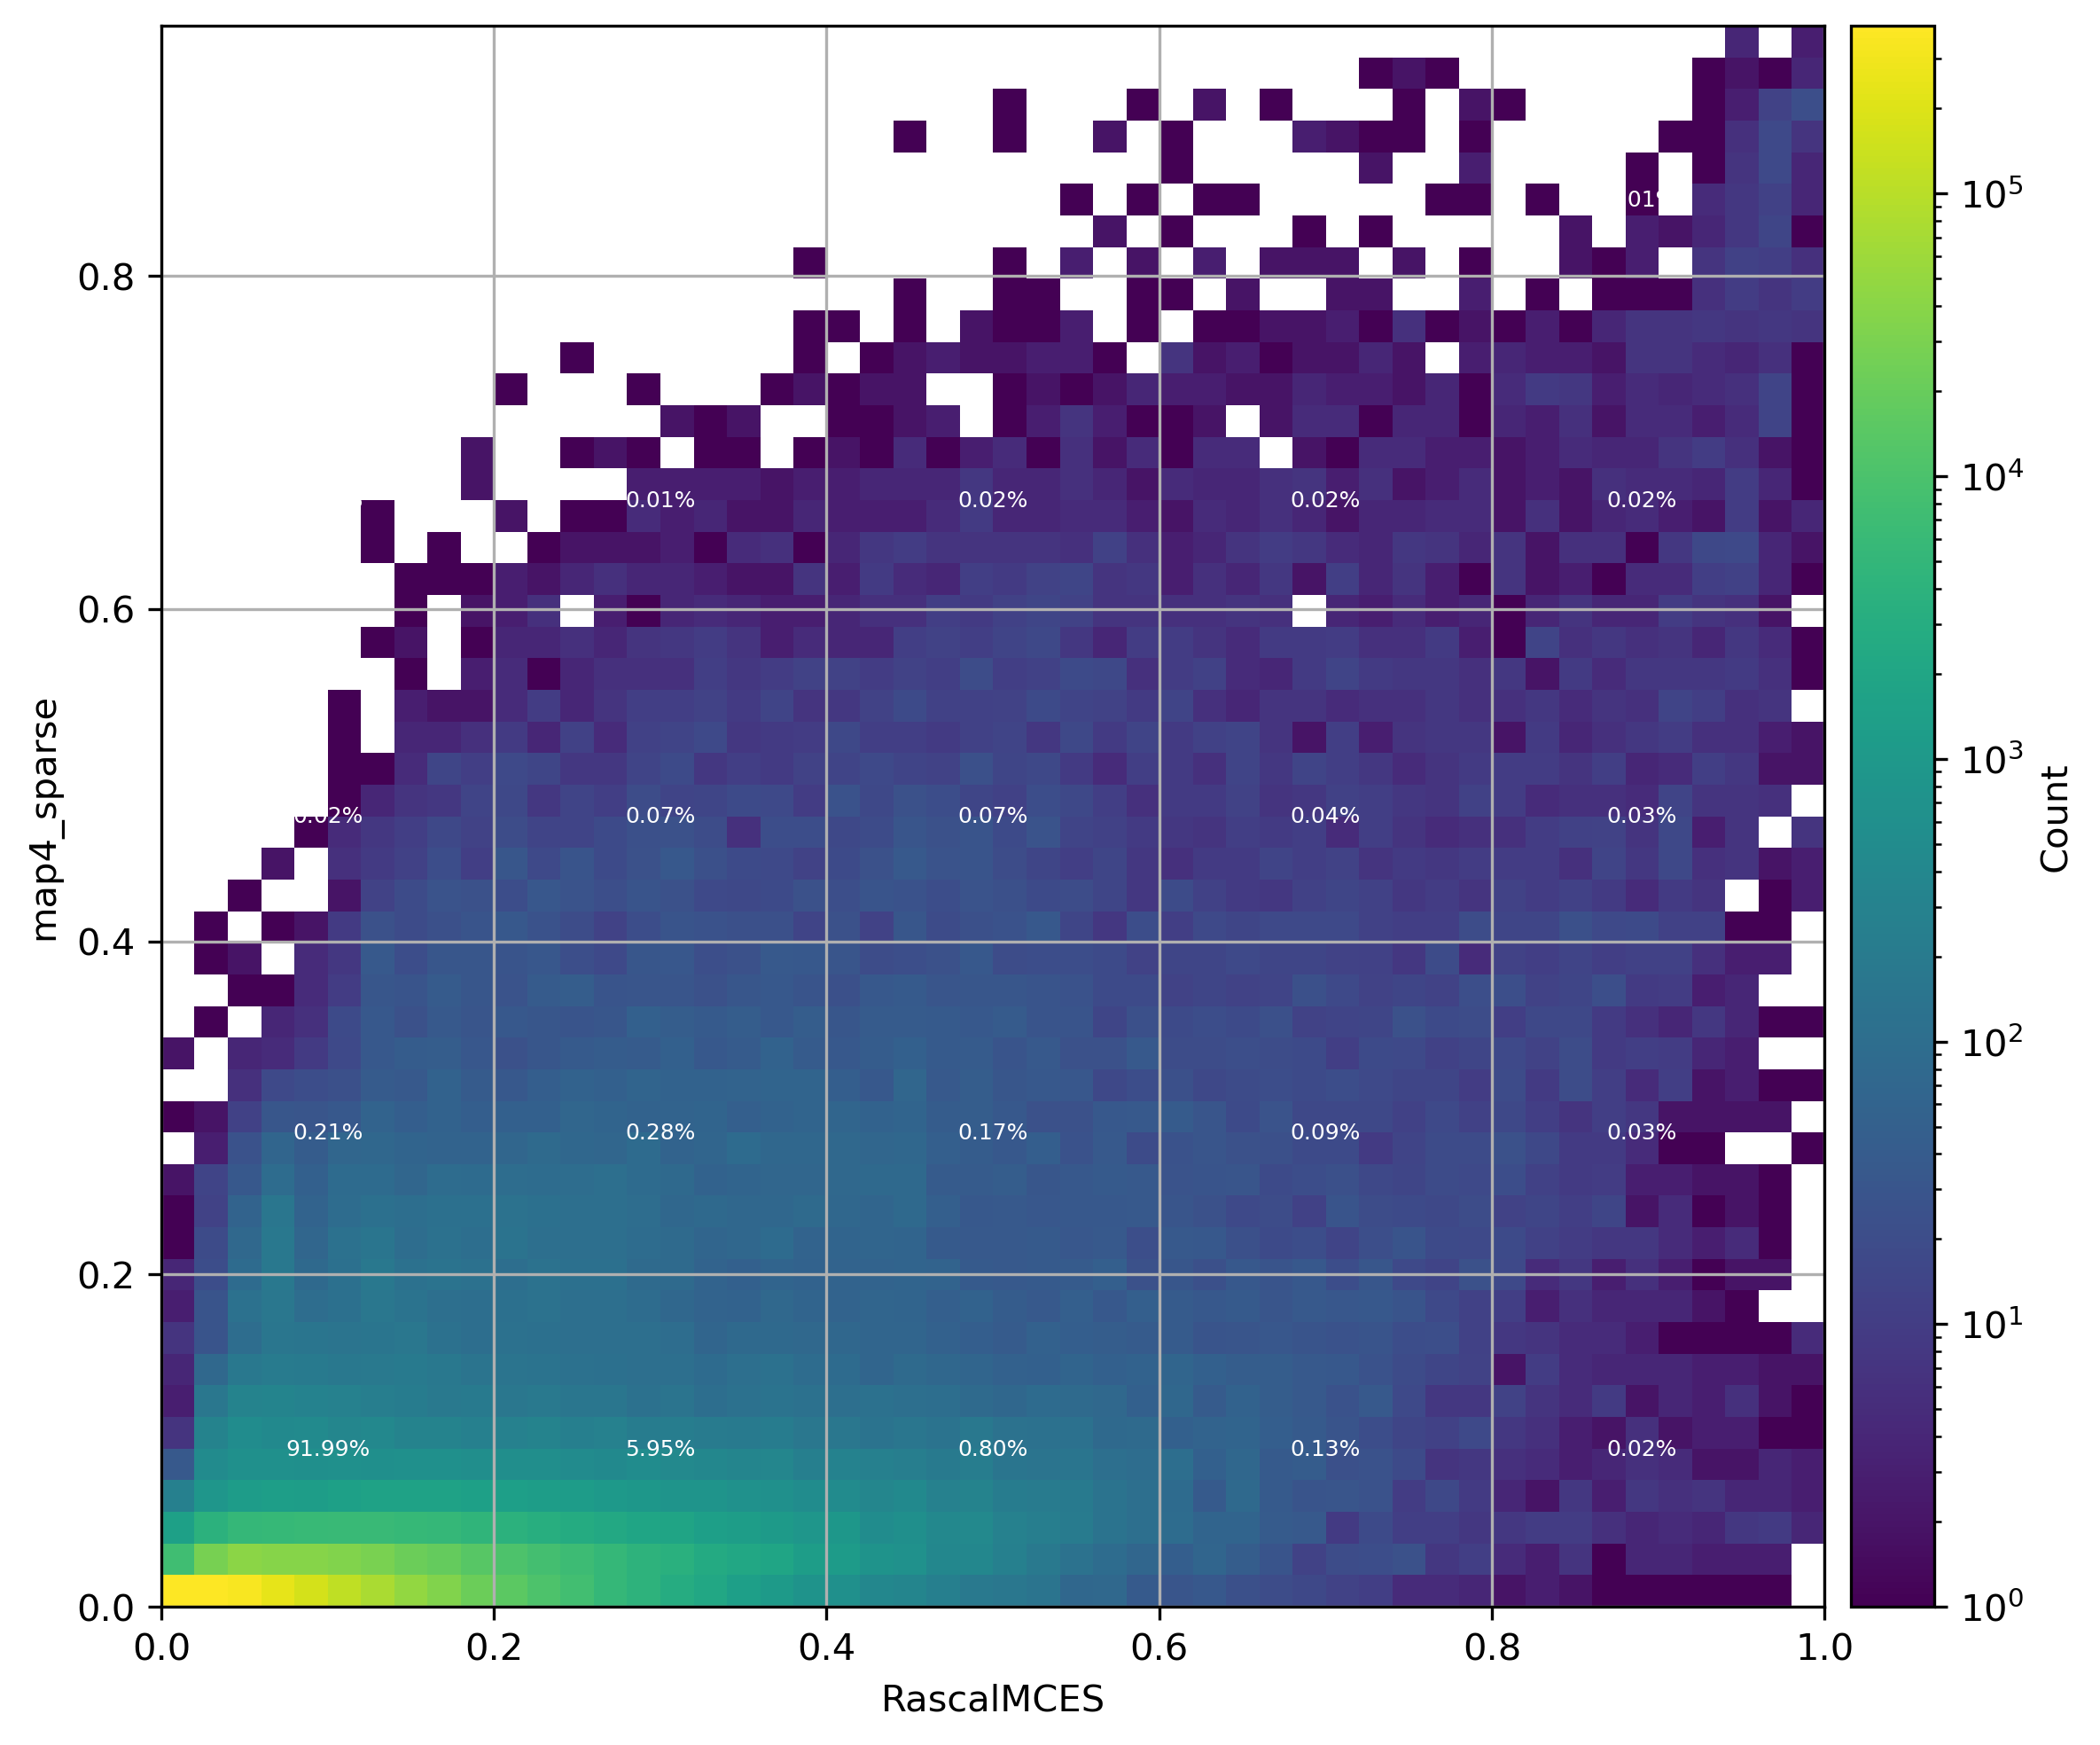

Pearson correlation between map4_sparse and rascalMCES: 0.57188


In [22]:
#results = {}

for experiment in experiments:
    (name, fpgen, count) = experiment

    plot_filename = os.path.join(path_results, f"{name}_rascal_comparison.png")
    if os.path.exists(plot_filename):
        print(f"----- Found existing results for experiment: {name} -----")
        print(f"----- (experiment will be skipped) -----")
        continue
    print(f"----- Experiment: {name} -----")

    if "_sparse" in name:
        if "map" in name:
            fingerprints = compute_sparse_map_fingerprints_from_smiles_serial(compounds.smiles, fpgen)
        else:
            fingerprints = compute_fingerprints_from_smiles(
                compounds.smiles, fpgen, sparse=True,
                count=count, progress_bar=True
            )
        print(f"Collected {len(fingerprints)} sparse fingerprints.")

        #if "count" in name:
        #    similarities = ruzicka_similarity_matrix_sparse(fingerprints, fingerprints)
        #else:
        #    similarities = jaccard_similarity_matrix_sparse(fingerprints, fingerprints)
        
    else:
        if "map" in name:
            fingerprints = compute_map_fingerprints_from_smiles(compounds.smiles, fpgen)
            fingerprints = np.stack(fingerprints)
        else:
            fingerprints = compute_fingerprints_from_smiles(
                compounds.smiles, fpgen, sparse=False,
                count=count, progress_bar=True
            )
            fingerprints = np.stack(fingerprints)
        print(f"Collected {fingerprints.shape[0]} fingerprints.")

        #if "count" in name:
        #    similarities = ruzicka_similarity_matrix(fingerprints, fingerprints)
        #else:
        #    similarities = jaccard_similarity_matrix(fingerprints, fingerprints)

    #print(f"Computed {similarities.shape[0]} x {similarities.shape[1]} similarity scores")


    if "_sparse" in name:
        if "_count" in name:
            metric = ruzicka_similarity_sparse_numba
        else:
            metric = jaccard_index_sparse
    else:
        if "_count" in name:
            metric = ruzicka_similarity
        else:
            metric = jaccard_index
    
    correlation = compare_scores(
        rascal_scores, fingerprints, metric,
        "RascalMCES", name,
        filename=plot_filename)
    print(f"Pearson correlation between {name} and rascalMCES: {correlation:.5f}")
    results[name] = correlation

    pd.DataFrame(results.items()).to_csv("results_rascal_correlations.csv", index=False)

In [23]:
results_df = pd.DataFrame(results.items())
results_df.columns = ["experiment", "Pearson correlation"]
results_df = results_df.sort_values("experiment")
results_df = results_df.set_index("experiment")
results_df

,Pearson correlation
experiment,
map2,0.441052
map2_sparse,0.601019
map4,0.130864
map4_sparse,0.571881
morgan12_count,0.625434
morgan12_count_sparse,0.651514
morgan2_binary,0.562345
morgan2_binary_sparse,0.574007
morgan2_count,0.556758


In [26]:
results_df.sort_values("Pearson correlation")

,Pearson correlation
experiment,
map4,0.130864
map2,0.441052
rdkit,0.464571
morgan2_count,0.556758
morgan2_binary,0.562345
morgan2_count_sparse,0.562800
morgan3_binary,0.563071
morgan3_count,0.567326
map4_sparse,0.571881


In [24]:
results_df.to_csv("results_racal_correlations.csv")